### Initialize

In [1]:
# Bunch of imports 
import therpy as tp
import zsharp as zs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import scipy.optimize
import scipy.special
import re
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import ipywidgets
import mpmath

cst = tp.cst(sigmaf=0.5, trapw = 2*np.pi*23.35)
bec1db = bec1db_package.Tullia(delta=20)
twopi = 2 * np.pi
kHz = 1e3 * cst.h

The servers are not connected!
Using the local database copy. Could be outdated!


C:\ProgramData\Anaconda3\lib\site-packages\pyfits-3.5-py3.7-win-amd64.egg\pyfits\__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:

def lorentian_fitfun(f, f0, gamma, amp=1, offset=0):
    return amp * (gamma/2)**2 / ((f-f0)**2 + (gamma/2)**2) + offset

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort_values('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
        print(df.head(2))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

In [3]:
# Useful snippets 
# Constants 
import_params = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'SeqMode']

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=1000, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.35,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.1, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )



In [4]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.35):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.35, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N

# Special Functions
def hybrid_total_atoms(kT, mu, trapf=23.35, cross_section=np.pi*(58e-6)**2):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    n_0 = UFG.density(kT, mu)
    z_max = 0
    while True:
        z_max += 50e-6
        if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
    z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
    n = UFG.density(kT, mu - u_* z**2)
    N = np.trapz(n, z) * cross_section
    return N

Basic Setup

In [5]:
# # Initialize Dataframe 
# df = get_from_clipboard(init=True)
# var = ['ExpansionTime','SideGreenEvap','WaitBox','IREvap','HeatTime','BoxShakeTime']
# x_var = 'WaitBox'

# # Import from Clipboard
# df = get_from_clipboard(df=df, init=False, var=var, x_var=x_var, image_func=tp.Image, using=0)

# # Define Settings 
# settings = {**default_settings, 
#             **dict(center_x = 1032, center_y = 1224, width=1000, height=1000, fudge=1.82)}

# # Apply settings
# for i, r in df.iterrows():
#     r.image.set(**settings)

# # Tests
# test = 20
# print(df.image.iloc[test].name)
# df.image.iloc[test].plot_crop()
# print(df.x.iloc[test])

# # Atom number
# df['total_atoms'] = [im.total_atoms for im in tqdm(df.image)]
# nums = df['total_atoms'].values
# plt.plot(nums)

# # roi
# width, height = 50, 50
# center = [df.image.iloc[0].app.shape[1] // 2, df.image.iloc[0].app.shape[0] // 2]
# center = np.array(center) + np.array([0, 0])
# roi = [slice(center[1] - height, center[1] + height + 1), slice(center[0] - width, center[0] + width + 1)]
# plt.imshow(df.image.iloc[0].app[roi])

# Imaging Resonances

## Side - Low Magnification - Ultra Low Intensity

In [ ]:
# Entire Code Here 

print("\n============== LOADING IMAGES ==============")
# Initialize Dataframe
df = get_from_clipboard(init=True)
var = ['ImagFreq0','ImagFreq1','ImagFreq2','ImgPower1','ImgPower2']
x_var = 'ImagFreq0'

df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)

# If ImagFreq0 is no good, use ImagFreq1
# x_var = 'ImagFreq1'
# df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)

print("Total Images {}".format(df.shape[0]))
plt.show()

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 107, center_y = 372, width=150, height=150, 
                   subsample=1, od_method='log', bg_width=5)}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)

# Tests
print("\n============== Testing Crop Settings ==============")
test = 0
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

# ROI
print("\n============== Testing Region Of Interest ==============")
center_offset = [0, 0]
width, height = 150, 150
roi = tp.get_cropi(df.image.iloc[test].od, 
                 center=(df.image.iloc[test].od.shape[1]//2 + center_offset[1], df.image.iloc[test].od.shape[0]//2 + center_offset[0]), 
                 width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Fitting
print("\n============== Fitting ==============")
def imsum(od):
    od = od[roi]
    od = od[np.abs(od) < 10000]
    return np.nansum(od)
df['total_atoms'] = np.array([imsum(im.od) for im in df.image])
c = tp.Curve(x = np.array(df.x), y = np.array(df.total_atoms))
c.removenan() 
res_curve = tp.Curve(x = c.x, y = c.y/c.y.max()).sortbyx() 
guess = [res_curve.x.mean(), 3, 1, 0] 
fitres, fiterr = res_curve.fit(lorentian_fitfun, guess, 
                       plot=True)
plt.show()


# Bootstrapping 
print("\n============== Bootstrapping ==============")
runs = 1000
frs = []

for i in range(runs):
    usei = np.arange(res_curve.x.size)
    usei = np.random.choice(usei, usei.size)
    c_temp = tp.Curve(x = res_curve.x[usei], y = res_curve.y[usei])
    frs.append(c_temp.fit(lorentian_fitfun, guess, plot=False)[0])
frs = np.array(frs)

# plots
fig, ax = plt.subplots(figsize=[10,4], ncols=2)
ax[0].hist(frs[:, 0],20)
ax[0].axvline(fitres[0], color='red', linestyle='--')
ax[0].axvline(fitres[0]-fiterr[0], color='black', linestyle='--')
ax[0].axvline(fitres[0]+fiterr[0], color='black', linestyle='--')
ax[0].set(title='Resonance Frequency : Bootstrapping')
ax[1].hist(frs[:, 1]*2,20)
ax[1].axvline(fitres[1]*2, color='red', linestyle='--')
ax[1].axvline(fitres[1]*2-fiterr[1]*2, color='black', linestyle='--')
ax[1].axvline(fitres[1]*2+fiterr[1]*2, color='black', linestyle='--')
ax[1].set(title=r'$\Gamma$ : Bootstrapping')
fig.tight_layout() 
plt.show()


# Plot 
print("\n============== Main Plot ==============")
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot2grid((5,1), (0,0), rowspan=3)
ax2 = plt.subplot2grid((5,1), (3,0), sharex=ax1)
ax3 = plt.subplot2grid((5,1), (4,0), sharex=ax1)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax1.get_xaxis().set_tick_params(direction='in')
ax2.get_xaxis().set_tick_params(direction='in')

ax1.plot(*res_curve.plotdata,'o')
ax1.plot(*res_curve.xyfitplot,'k-')
# ax1.axvline(fitres[0], c='k', linestyle='--', alpha=0.5)
ax1.axvline(fitres[0] + fiterr[0], c='k', linestyle='--', alpha=0.25)
ax1.axvline(fitres[0] - fiterr[0], c='k', linestyle='--', alpha=0.25)
ax2.plot(res_curve.x, res_curve.y - res_curve.yfit,'o')
ax2.vlines(res_curve.x, res_curve.x*0, res_curve.y - res_curve.yfit)
ax3.plot(df.x, [im.Ii_avg for im in df.image],'o')

ax1.set(ylabel='Optical Density [Arb.]', title=r'f$_0$ = {:.1f} and $\Gamma$ = {:.1f} +- {:.1f} MHz'.format(fitres[0], fitres[1]*2, fiterr[1]*2))
ax2.set(ylabel='Res.')
ax3.set(xlabel='Imaging Frequency Cicero [Double Pass]', ylabel='Counts')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

print('''S1 : {:.2f} +- {:.2f}
S2 : {:.2f}
S3 : {:.2f}'''.format(fitres[0], fiterr[0], fitres[0] + 38.63, fitres[0] + 80.67))


## Side - High Magnification

## Top - Double Imaging

## Top - Single Imaging

# RF Spectroscopy

## Theory - Polarized

In [ ]:
@np.vectorize
def rabi_oscillation(tau=0, fR=3e3, delta=0, f=None, f0=None):
    if (f0 is not None) and (f is not None): delta = f0-f
    elif f0 is not None: delta=0.0
    elif f is not None: delta=0.0
    return fR**2 / (fR**2 + delta**2) * np.sin(np.pi * tau * (fR**2 + delta**2)**(1/2))**2

In [ ]:
# vs. detuning plots
def vs_detuning(delta=1.0, fR=0.5, tau=1.0, points=15):
    delta = np.linspace(-delta, delta, points) * 1e3
    tsf = rabi_oscillation(tau = tau * 1e-3, fR = fR * 1e3, delta = delta)
    plt.plot(delta / 1e3, tsf, 'o-')
    plt.xlabel('Detuning [kHz]')
    plt.ylabel('Transfer Fraction')
    plt.title("Rabi Resonance; spacing {:.3f} kHz".format((delta[1]-delta[0])/1e3 ))
ipywidgets.interact(vs_detuning, delta = (0.1, 2, 0.05), fR = (0.1, 3, 0.05), tau = (0.2, 3, 0.05), points = (1, 30, 1))

In [ ]:
rabi2volt(0.5)

## vs. Detuning - Polarized

In [ ]:
# Entire Code Here 

print("\n============== LOADING IMAGES ==============")
var = ['RFspect','PulseTime','SpectVolt']
x_var = 'RFspect'

df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)
print("Total Images {}".format(df.shape[0]))
plt.show()

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1185, center_y = 1385, width=800, height=1500, )}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)

# Tests
print("\n============== Testing Crop Settings ==============")
test = 0
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

# ROI
print("\n============== Testing Region Of Interest ==============")
center_offset = [0, 0]
width, height = 75, 60
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Atom num selection
print("\n============== Atom Nums ==============")
keep = 0.20
offset = 1 + 0.0
df['total_atoms'] = np.array([np.nansum(im.app[roi]) for im in tqdm(df.image, desc='Atoms')])
x = df.shot[::2].values
nA = df.total_atoms[::2].values
nB = df.total_atoms[1::2].values
nTotal = nA + nB
median_numbers = np.median(nTotal)
using = (nTotal >= median_numbers * (offset - keep)) & (nTotal <= median_numbers * (offset + keep))
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(x, nTotal/1e6, '.-', label='all')
ax[0].plot(x[~using], nTotal[~using]/1e6, 'rx', label='Removed Shots')
ax[1].plot(x[using], nTotal[using] / median_numbers, 'o-')
ax[0].legend()
plt.show()

rabi_osc = tp.Curve(df.x[::2].values[using]*1e6, nB[using] / nTotal[using]).sortbyx()


# Fit
print("\n============== Fitting ==============")
tau = 1e-3
def fitfun(w, w0, wR, offset=0):
    amp = (wR**2)/(wR**2 + (w-w0)**2) 
    phase = np.pi*tau*np.sqrt(wR**2+(w0-w)**2)
    return amp * (np.sin(phase))**2 + offset
#     return amp * (np.sin(phase))**2
guess = [76.0327e6, 0.4e3, 0]
# guess = [82.713e6, 0.4e3, 0]
fitres, fiterr = rabi_osc.fit(fitfun, guess, plot=True)
plt.show()

# Plots 
plt.plot((rabi_osc.x - fitres[0])/1e3, rabi_osc.y,'.')
plt.plot((rabi_osc.xyfitplot[0] - fitres[0])/1e3, rabi_osc.xyfitplot[1],'--')
plt.xlabel('Detuning [kHz]')
plt.ylabel('Transfer')
plt.legend(['Data','Fit'])
plt.title('$f_0$ {:.4f} MHz  and  $f_R$ {:.3f} $\pm$ {:.3f} kHz'.format(fitres[0]/1e6, fitres[1]/1e3, fiterr[1]/1e3))
plt.tight_layout()
plt.show()

# Bootstrapping 
runs = 1000
f0s = []

for i in range(runs):
    usei = np.arange(rabi_osc.x.size)
    usei = np.random.choice(usei, usei.size)
    c_temp = tp.Curve(x = rabi_osc.x[usei], y = rabi_osc.y[usei])
    f0s.append(c_temp.fit(fitfun, fitres, plot=False)[0][0] / 1e6)
f0s = np.array(f0s)
subtract = 76.032
# plots
fig, ax = plt.subplots(figsize=[6,4])
ax.hist((f0s-subtract)*1000,40)
ax.axvline((fitres[0]/1e6-subtract)*1000, color='red', linestyle='--')
ax.axvline(((fitres[0]-fiterr[0])/1e6-subtract)*1000, color='black', linestyle='--')
ax.axvline(((fitres[0]+fiterr[0])/1e6-subtract)*1000, color='black', linestyle='--')
ax.set(title='Bootstrapping : f0 : {:.5f} +- {:.5f} MHz'.format(fitres[0]/1e6, fiterr[0]/1e6))
ax.set(xlabel='(f0 - {})*1000'.format(subtract), ylabel='Histogram')
fig.tight_layout()
plt.show()

## vs. Pulse Time - Polarized

## vs. Rabi Frequency - Polarized

## Box Contact - Double Imaging

In [ ]:
# Load Images 

# Load Images
var = ['IREvap', 'SideGreenEvap', 'HeatWait', 'PulseTime', 'RFspect', 'Spect Volt', ]
x_var = 'PulseTime'
df_all = get_from_clipboard(x_var = x_var, image_func=tp.Image, var=var, using=2, display=False)

# Crop images
settingsA = {**default_settings, 
             **dict(center_x = 1152, center_y = 1270, width = 600, height = 600, fudge = 1)}
settingsB = {**settingsA, **dict(width = 1200, height = 1200)}

for i, r in df_all[0::2].iterrows(): r.image.set(**settingsA)
for i, r in df_all[1::2].iterrows(): r.image.set(**settingsB)

# Test
test = 4*2
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df_all.image.iloc[test+0].plot_crop(ax=ax[0:2])
df_all.image.iloc[test+1].plot_crop(ax=ax[2:4])

plt.tight_layout()
plt.show()

In [ ]:
# Atom Number fluctuations 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
using = atom_num_filter(df_all.iloc[1::2], keep=0.10, offset=0.0)
using = np.array([using, using]).T.flatten()
df = df_all[using]

In [ ]:
# Define ROI and test  
avg_od_A = np.nanmean([im.od for im in df.image[0::2]], axis=0)
avg_od_B = np.nanmean([im.od for im in df.image[1::2]], axis=0)
roiA = get_roi(avg_od_A, center=[-4, 3], width=65, height=60)
roiB = get_roi(avg_od_B, center=[0, 0], width=250, height=230)

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=[14,6])
ax = ax.flatten()

clim = [-0.05,0.2]
w = 10
s = avg_od_A.shape
ax[0].imshow(avg_od_A, clim=clim, origin='lower')
ax[0].axvline(roiA[1].start, color='w', linestyle='--',alpha=0.7)
ax[0].axvline(roiA[1].stop-1, color='w', linestyle='--',alpha=0.7)
ax[0].axhline(roiA[0].start, color='w', linestyle='--',alpha=0.7)
ax[0].axhline(roiA[0].stop-1, color='w', linestyle='--',alpha=0.7)
ax[1].imshow(avg_od_A[roiA], clim=clim, origin='lower')
ax[2].plot(np.nansum(avg_od_A[s[0]//2-w:s[0]//2+w, :], axis=0))
ax[2].axhline(0, color='k', linestyle='--',alpha=0.5)
ax[2].axvline(roiA[1].start, color='k', linestyle='--',alpha=0.5)
ax[2].axvline(roiA[1].stop-1, color='k', linestyle='--',alpha=0.5)
ax[3].plot(np.nansum(avg_od_A[:,s[1]//2-w:s[1]//2+w], axis=1))
ax[3].axhline(0, color='k', linestyle='--',alpha=0.5)
ax[3].axvline(roiA[0].start, color='k', linestyle='--',alpha=0.5)
ax[3].axvline(roiA[0].stop-1, color='k', linestyle='--',alpha=0.5)

clim = [-0.1,0.1]
w = 10
s = avg_od_B.shape
ax[4].imshow(avg_od_B, clim=clim, origin='lower')
ax[4].set(xlabel='x', ylabel='y')
ax[4].axvline(roiB[1].start, color='w', linestyle='--',alpha=0.7)
ax[4].axvline(roiB[1].stop-1, color='w', linestyle='--',alpha=0.7)
ax[4].axhline(roiB[0].start, color='w', linestyle='--',alpha=0.7)
ax[4].axhline(roiB[0].stop-1, color='w', linestyle='--',alpha=0.7)
ax[5].imshow(avg_od_B[roiB], clim=clim, origin='lower')
ax[5].set(xlabel='x', ylabel='y')
ax[6].plot(np.nansum(avg_od_B[s[0]//2-w:s[0]//2+w, :], axis=0))
ax[6].axhline(0, color='k', linestyle='--',alpha=0.5)
ax[6].set(xlabel='x')
ax[6].axvline(roiB[1].start, color='k', linestyle='--',alpha=0.5)
ax[6].axvline(roiB[1].stop-1, color='k', linestyle='--',alpha=0.5)
ax[7].plot(np.nansum(avg_od_B[:,s[1]//2-w:s[1]//2+w], axis=1))
ax[7].axhline(0, color='k', linestyle='--',alpha=0.5)
ax[7].set(xlabel='y')
ax[7].axvline(roiB[0].start, color='k', linestyle='--',alpha=0.5)
ax[7].axvline(roiB[0].stop-1, color='k', linestyle='--',alpha=0.5)
fig.tight_layout()

In [ ]:
# RF Spectrum Data  

# Total Atoms 
n_tsf = np.array([np.nansum(im.app[roiA]) for im in df.image[0::2]])
n_up  = np.array([np.nansum(im.app[roiB]) for im in df.image[1::2]])

# Remove BG 
n_bg = np.mean([np.nansum(im.app[roiA]) for im in df.image[df.x == 0][0::2]])
n_bg = np.nan_to_num(n_bg) # If there are no bg images 
n_tsf -= n_bg

# Data 
rf_spectra = tp.Curve(df.x[::2].values, n_tsf/n_up).sortbyx()
rf_spectra_binned = bin_data(*rf_spectra.data)

# Plots 


In [ ]:
plt.plot(*rf_spectra.data, '.')

$$ \tilde{C} = \frac{C}{2 N_\uparrow k_F} =  \omega^{3/2} \frac{n_{tsf}}{n_\uparrow k_F} \frac{4\pi}{\Omega_R^2 \tau} \sqrt{\frac{m}{\hbar}} = \left( \omega^{3/2} \frac{4 \pi}{\Omega^2_R} \sqrt{\frac{m}{\hbar}} \right) \frac{n_{tsf}}{n_\uparrow k_F \tau}$$

From experimental data, we find $ \frac{n_{tsf}}{n_\uparrow k_F \tau} $

### Tests

In [ ]:
# Fits for the TOF images to get ~ Temperature 
# [cx, cy, sx, sy, amp, offset, angle]
fr = []
for im in tqdm(df.image[1::2]):
    fr_ = fit_gaussian_2d(im.app, plot=False)
    fr.append([*fr_, np.mean(fr_[2:4])])
fr = np.array(fr)
plt.plot(df.x[::2], fr[:, 7], 'o')
plt.xlabel('x variable')
plt.ylabel(r'Mean $\sigma$ for TopB TOF')
plt.tight_layout()

In [ ]:
# Various Fitting -- Exponential 
def fitfun(t, gamma, tau, offset=0): return gamma * tau * (1-np.exp(-t/tau)) + offset

# Simple exp fit 
cutoff = 0.7
fr, fe = rf_spectra.fit(fitfun, [1, 1, 0], plot=False, xlim=[-1, cutoff])
ax = plt.subplots()[1]
plt.plot(*rf_spectra.data, '.')
plt.plot(*rf_spectra.xyfitplot, '-')
plt.plot(rf_spectra.x, rf_spectra.x * fr[0] + fr[2])
plt.axvline(cutoff, linestyle='--', c='k', alpha=0.5)
plt.xlabel('Pulse Time [ms]')
plt.ylabel('Transfered Fraction [$N_2$ / $N_3$]')
plt.title('Sample Exp. Fit')
plt.show()

# Emitting ends 
limits = np.unique(rf_spectra.x)[2:]
gamma = []
for l in limits:
    fr, fe = rf_spectra.fit(fitfun, [1,1,0], xlim=[-1, l])
    gamma.append([fr[0], fe[0]])
gamma = np.array(gamma)

plt.figure()
plt.subplot(sharex=ax)
# plt.plot(limits, gamma[:,0], 'o')
plt.errorbar(limits, gamma[:,0], yerr=gamma[:,1], fmt='o')
plt.xlabel('Cutoff Time')
plt.ylabel('Gamma')
plt.title('Does Gamma change with cutoff?')
plt.show()

In [ ]:
# Various Fitting -- Polynomials 
def fitfun_poly(x, *args): return np.poly1d(args)(x)

# # Simple fit and plot 
polyfit = np.polyfit(*rf_spectra.data, 1)
poly1d = np.poly1d(polyfit)
plt.plot(*rf_spectra.data, '.')
plt.plot(rf_spectra.x, poly1d(rf_spectra.x))
plt.xlabel('Time [ms]')
plt.ylabel('Transfer Fraction [N2 / N3]')
plt.tight_layout()
plt.show()
print('Gamma {:.3f} per ms'.format(polyfit[-2]))

# Check slope of line vs order
order = np.arange(1, 10, 1)
gamma = [np.polyfit(*rf_spectra.data, o)[-2] for o in order]
plt.plot(order, gamma, 'o-')
plt.xlabel('Polynomial Order')
plt.ylabel('Linear Slope')
plt.title('Numpy Polyfits')
plt.tight_layout()
plt.show()

# # Fit LeastSq polynomial 
# fr_ = np.polyfit(*rf_spectra.data, 3)
# fr = rf_spectra.fit(fitfun_poly, fr_*0, plot=False)[0]
# print((fr_ - fr)/fr_*100)

# LstSq fit results vs order
order = np.arange(1, 10, 1)
gamma= []
for o in order:
    fr_ = np.polyfit(*rf_spectra.data, o)
    gamma.append(rf_spectra.fit(fitfun_poly, fr_*1.1, plot=False,)[0][-2])
gamma = np.array(gamma)
plt.plot(order, gamma, 'o-')
plt.xlabel('Polynomial Order')
plt.ylabel('Slope')
plt.title('Least Sq. Fitting')
plt.tight_layout()
plt.show()

# Polyfit with cutoff 
order = 5
limits = np.unique(rf_spectra.x)[2:]
gamma = [np.polyfit(*rf_spectra.trim(xlim=[-1, l]).data, order)[-2] for l in limits]
gamma = np.array(gamma)
plt.figure()
plt.plot(limits, gamma, 'o-')
# plt.errorbar(limits, gamma[:,0], yerr=gamma[:,1], fmt='o')
plt.xlabel('Cutoff Time')
plt.ylabel('Gamma')
plt.title('Does Gamma change with cutoff?')
plt.show()

# LstSq fit with cutoff 


In [ ]:
# Various Fitting -- Including varying error 


# Trap Characterization

## Trap Frequency - ODT

## Trap Frequency - Hyrbid

## Box Top - Sharpness, Radius, Length, P(n), 

### Load

In [523]:
# Load Images 

# Initialize Dataframe
df = get_from_clipboard(init=True, using=2)
var = ['IRevap','SideGreenEvap','SideGreenPower', 'TopGreenPower', 'SideGreenReramp']
x_var = 'IRevap'

# Import from Clipboard
df = get_from_clipboard(df=df, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=2, display=True)


Updating the local database...
Done
Pasted Sample :  ['02-06-2019_19_25_40_TopA', '02-06-2019_19_25_40_TopB']
Newly added images       : 10
Total number of images   : 10
                       name         image  shot     x  IRevap  SideGreenEvap  \
0  02-06-2019_19_21_54_TopA  Image object   0.0  0.75    0.75           0.38   
1  02-06-2019_19_21_54_TopB  Image object   0.5  0.75    0.75           0.38   

   SideGreenPower  TopGreenPower  SideGreenReramp  
0             3.0            1.0              1.5  
1             3.0            1.0              1.5  



============== Testing Crop Settings ==============
02-06-2019_19_21_54_TopA
0.75


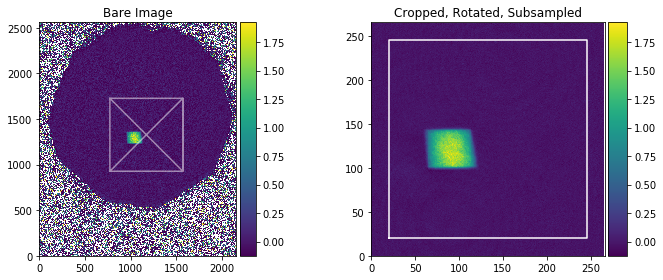

In [524]:
# Define Settings  
settings = {**default_settings, 
            **dict(center_x = 1172, center_y = 1327, width=800, height=800, fudge=1, subsample=3, od_method='table')}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)
    
# Tests
print("\n============== Testing Crop Settings ==============")
test = 0
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

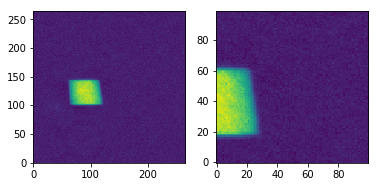

In [525]:
# ROI 
test = 0
center_offset = [10, 0]
width, height = 100, 100
roi = tp.get_cropi(df.image.iloc[test].od, 
                             center=(df.image.iloc[test].od.shape[1]//2 + center_offset[0], df.image.iloc[test].od.shape[0]//2 + center_offset[1]), 
                             width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

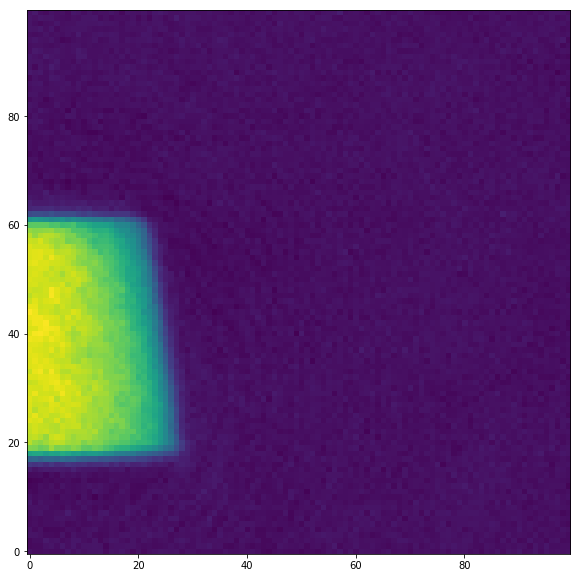

In [526]:
# Averaged Image 
mean_app = np.mean([im.app for im in df.image[0::2]], axis=0)
plt.figure(figsize=[10, 10])
plt.imshow(mean_app[roi], origin=0, )

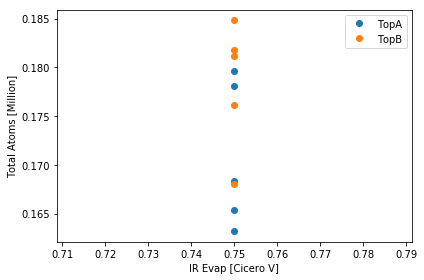

In [527]:
# Atom number vs x 
df['total_atoms'] = [np.nansum(im.app[roi]) for im in tqdm(df.image)]
plt.plot(df['x'].values[::2], df['total_atoms'].values[::2]/1e6,'o', label='TopA')
plt.plot(df['x'].values[1::2], df['total_atoms'].values[1::2]/1e6,'o', label='TopB')
plt.xlabel('IR Evap [Cicero V]')
plt.ylabel('Total Atoms [Million]')
plt.legend()
plt.tight_layout()

### Length, Radius, and Sigma

In [528]:
# Function Definitions 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x
def fitres_extract(frl, frw):
    length = abs(frl[1] - frl[0])
    sigma = np.mean([abs(frl[2]), abs(frl[3])])
    rad = frw[1]
    pix = df.image.iloc[0].pixel_binned * 1e6
    return (length*pix, rad*pix, sigma*pix)
def circle(x, x0, rad):
    y2 = rad**2 - (x-x0)**2
    y2[y2<=0] = 0
    return y2**0.5
def fitfun_rad(x, x0, rad, amp=1, offset=0):
    return circle(x, x0, rad)*amp + offset

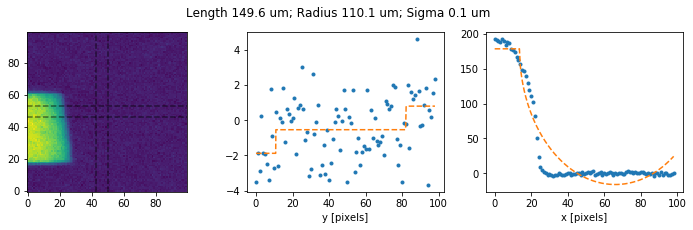

In [529]:
# Box Length and Radius -- Region of Interests 
test = 0
center_offset = [-3, 0]
width, height = 8, 8
roi_length = tp.get_cropi(df.image.iloc[test].od[roi], 
                                 center=(df.image.iloc[test].od[roi].shape[1]//2 + center_offset[0], df.image.iloc[test].od[roi].shape[0]//2 + center_offset[1]), 
                                 width=width, height=10000)
roi_width = tp.get_cropi(df.image.iloc[test].od[roi], 
                                 center=(df.image.iloc[test].od[roi].shape[1]//2 + center_offset[0], df.image.iloc[test].od[roi].shape[0]//2 + center_offset[1]), 
                                 width=10000, height=height)

# Error Function Fits
cl = tp.Curve(y = np.nanmean(df.image.iloc[test].app[roi][roi_length], axis=1))
gl = [cl.maxx/10, cl.maxx/10*9, 5, 5, cl.maxy, cl.maxy/100]
frl = cl.fit(fitfun_erf, gl, plot=False)[0]

# Radius fits
cw = tp.Curve(y = np.nanmean(df.image.iloc[test].app[roi][roi_width], axis=0))
gw = [cw.maxx/2, cw.maxx/2*0.8, cw.maxy, cw.maxy/100]
frw = cw.fit(fitfun_rad, gw, plot=False)[0]

fr = fitres_extract(frl, frw)
suptitle = 'Length {:.1f} um; Radius {:.1f} um; Sigma {:.1f} um'.format(*fr)

fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
ax[0].imshow(df.image.iloc[test].app[roi], origin=0)
ax[0].axvline(roi_length[1].start, c='k', linestyle='--', alpha=0.5)
ax[0].axvline(roi_length[1].stop-1, c='k', linestyle='--', alpha=0.5)
ax[0].axhline(roi_width[0].start, c='k', linestyle='--', alpha=0.5)
ax[0].axhline(roi_width[0].stop-1, c='k', linestyle='--', alpha=0.5)
ax[1].plot(*cl.data, '.')
ax[1].plot(*cl.xyfitplot, '--')
ax[1].set(xlabel='y [pixels]')
ax[2].plot(*cw.data, '.')
ax[2].plot(*cw.xyfitplot, '--')
ax[2].set(xlabel='x [pixels]')
plt.suptitle(suptitle, y=1.05)
plt.tight_layout()

In [530]:
# Calculate for all 
results = []

for i, im in df.image.iteritems():
    # Error Function Fits
    cl = tp.Curve(y = np.nanmean(im.app[roi][roi_length], axis=1))
    gl = [cl.maxx/10, cl.maxx/10*9, 5, 5, cl.maxy, cl.maxy/100]
    frl = cl.fit(fitfun_erf, gl, plot=False)[0]
    # Radius fits
    cw = tp.Curve(y = np.nanmean(im.app[roi][roi_width], axis=0))
    gw = [cw.maxx/2, cw.maxx/2*0.8, cw.maxy, cw.maxy/100]
    frw = cw.fit(fitfun_rad, gw, plot=False)[0]
    # Store results
    results.append(fitres_extract(frl, frw))

# Store in dataframe
results = np.array(results)
df['length'] = results[:, 0]
df['radius'] = results[:, 1]
df['sigma'] = results[:, 2]

CAN'T FIT, Returning Original Guess: Details of Error Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
CAN'T FIT, Returning Original Guess: Details of Error Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


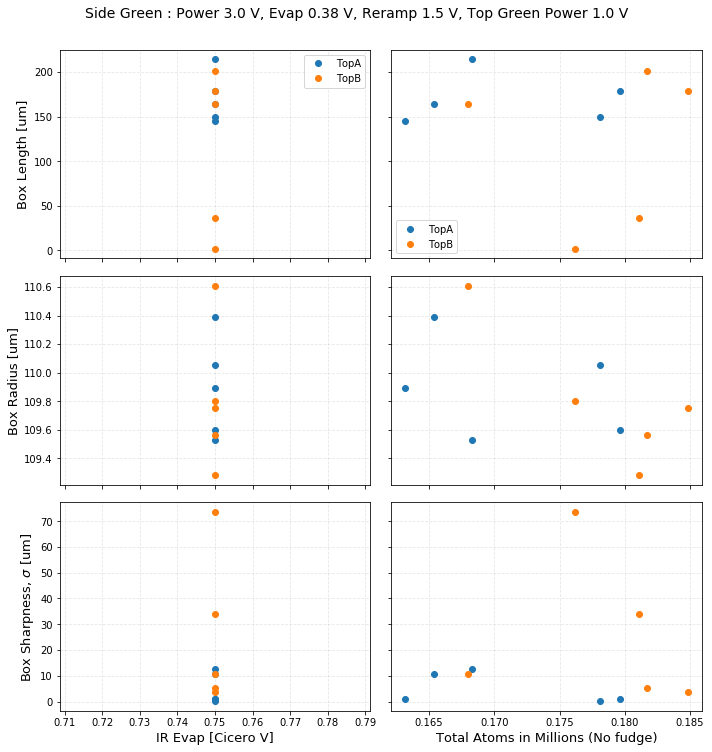

In [531]:
# Plot Results -- TopA and TopB separate, vs x and total_atoms 
vals = np.unique(df.SideGreenPower)[0], np.unique(df.SideGreenEvap)[0], np.unique(df.SideGreenReramp)[0], np.unique(df.TopGreenPower)[0]
suptitle = "Side Green : Power {} V, Evap {} V, Reramp {} V, Top Green Power {} V".format(*vals)
fontsize = 13

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(321)
plt.plot(df.x[::2], df.length[::2], 'o', label='TopA')
plt.plot(df.x[1::2], df.length[1::2], 'o', label='TopB')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Box Length [um]', fontsize=fontsize)
plt.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(323, sharex=ax1)
plt.plot(df.x[::2], df.radius[::2], 'o')
plt.plot(df.x[1::2], df.radius[1::2], 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Box Radius [um]', fontsize=fontsize)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(325, sharex=ax1)
plt.plot(df.x[::2], df.sigma[::2], 'o')
plt.plot(df.x[1::2], df.sigma[1::2], 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Box Sharpness, $\sigma$ [um]', fontsize=fontsize)
plt.xlabel('IR Evap [Cicero V]', fontsize=fontsize)

ax4 = plt.subplot(322, sharey=ax1)
plt.plot(df.total_atoms[::2]/1e6, df.length[::2], 'o', label='TopA')
plt.plot(df.total_atoms[1::2]/1e6, df.length[1::2], 'o', label='TopB')
plt.grid(linestyle='--', alpha=0.3)
plt.legend()
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

ax5 = plt.subplot(324, sharex=ax4, sharey=ax2)
plt.plot(df.total_atoms[::2]/1e6, df.radius[::2], 'o')
plt.plot(df.total_atoms[1::2]/1e6, df.radius[1::2], 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)

ax6 = plt.subplot(326, sharex=ax4, sharey=ax3)
plt.plot(df.total_atoms[::2]/1e6, df.sigma[::2], 'o')
plt.plot(df.total_atoms[1::2]/1e6, df.sigma[1::2], 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.xlabel('Total Atoms in Millions (No fudge)', fontsize=fontsize)
plt.setp(ax6.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=0.04)
plt.subplots_adjust(wspace=0.03)

plt.suptitle(suptitle, y=1.04, fontsize=14)
plt.tight_layout()

In [532]:
# Print averaged length and radius of TopA 
info = {}
info['radius'] = np.mean(df.iloc[::2].radius.values)
info['radius err'] = np.std(df.iloc[::2].radius.values) 
info['length'] = np.mean(df.iloc[::2].length.values)
info['length err'] = np.std(df.iloc[::2].length.values) 
info['volume']=info['radius']**2*cst.pi*info['length']
info['volume err']=info['volume']*(np.sqrt((info['radius err']/info['radius'])**2+(info['length err']/info['length'])**2))


print(r"Radius {:.2f} +/- {:.2f} um".format(info['radius'], info['radius err']))
print(r"Length {:.2f} +/- {:.2f} um".format(info['length'], info['length err']))
print(r"Volume {:.3f} +/- {:.3f} X 10^6 um^3".format(info['volume']/1e6, info['volume err']/1e6))

Radius 109.89 +/- 0.31 um
Length 170.26 +/- 24.94 um
Volume 6.460 +/- 0.946 X 10^6 um^3


### Outline

In [533]:
import skimage.filters
import skimage.measure
from skimage.measure import label, regionprops
import math

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\thresholding.py:229: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,


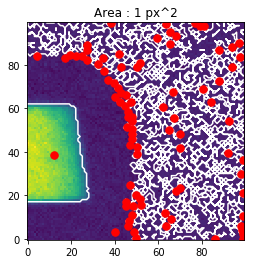

In [534]:
test = 0

img = df.image.iloc[test].app[roi]
mask = skimage.filters.threshold_adaptive(img, 51, method='mean')
contours = skimage.measure.find_contours(mask, 0)
label_img = label(mask)
regions = regionprops(label_img)

plt.imshow(img, origin=0)
# plt.imshow(mask, cmap='gray', alpha=0.2, origin=0)
for c in contours:
    plt.plot(c[:,1], c[:,0], '-w')
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    plt.plot(x0, y0, '.r', markersize=15)
    plt.title('Area : {} px^2'.format(props.filled_area))

In [535]:
# Need to fit lines to the four sides

### Center of the Box

In [536]:
# Adjust parameters for box cross-section
params = dict(xsec_extension='linear', xsec_slice_width=2, xsec_fit_range=1.1, radial_selection=0.5)

def temp_func(test=0,):
    fig, ax = plt.subplots(ncols=2, figsize=[8, 4])
    df.image.iloc[test].set(**params)
    df.image.iloc[test].xsec.infoplot(axs=ax)
    plt.tight_layout()

if df.shape[0] <= 2:
    temp_func(0)
else:
    ipywidgets.interact(temp_func, test=(0, df.shape[0]-2, 2));

interactive(children=(IntSlider(value=0, description='test', max=8, step=2), Output()), _dom_classes=('widget-…

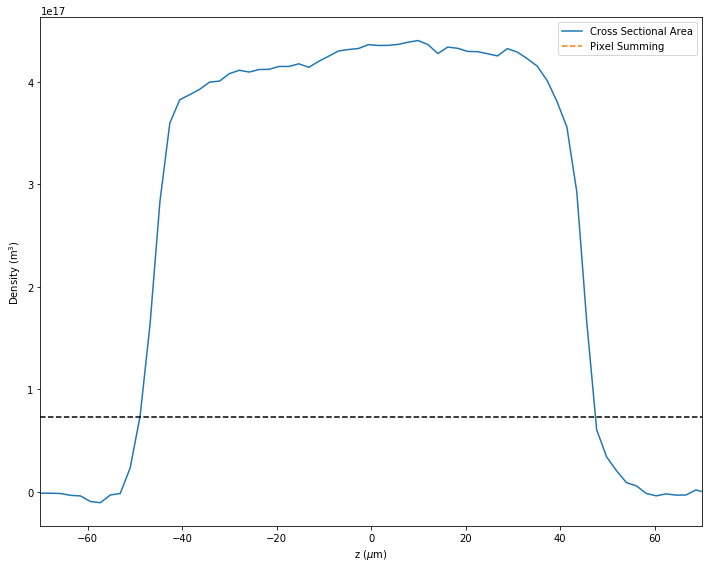

In [439]:
# Average n(z) for all images 
avg_atoms = np.mean([im.total_atoms for im in df.image[::2]])
nz_all = [tp.Curve(im.nz.x*1e6, im.nz.y / im.total_atoms * avg_atoms) for im in df.image[::2]]
nz_conc = tp.Curve(np.concatenate([c.x for c in nz_all]), np.concatenate([c.y for c in nz_all])).sortbyx()
nz = nz_conc.binbyx(bins = nz_all[0].x.size)

# Summing up the pixels for comparison 
Nz_all = [tp.Curve(im.nz.x*1e6, np.mean(im.app, axis=1) / im.total_atoms * avg_atoms) for im in df.image[::2]]
Nz_conc = tp.Curve(np.concatenate([c.x for c in Nz_all]), np.concatenate([c.y for c in Nz_all])).sortbyx()
Nz = Nz_conc.binbyx(bins = Nz_all[0].x.size)
multiplier = nz.y.sum() / Nz.y.sum()

# Plots for comparison
plt.figure(figsize=[10, 8])
plt.plot(*nz.data, label='Cross Sectional Area')
plt.plot(Nz.x, Nz.y * multiplier, '--', alpha=1, label='Pixel Summing')
plt.axhline(0.73e17, c='k', linestyle='--')
plt.legend()
plt.xlim([-70, 70])
plt.xlabel(r'z ($\mu$m)')
plt.ylabel(r'Density (m$^3$)')
plt.tight_layout()


In [440]:
# EXPERIMENTAL -- Fit erf + harmonic confinment 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x
def fitfun_erf_harmonic(x, x0, x1, x2, s0, s1, s2, a1=1, offset=0, slope=0):
    y1 = fitfun_erf(x, x1, x2, s1, s2, a1)
    y0 = (1 - ((x-x0)/s0)**2)
    y0[y0<=0] = 0
    return y1 * y0**(3/2) + offset + slope * x

def fitres_extract(frl, frw):
    length = abs(frl[1] - frl[0])
    sigma = np.mean([abs(frl[2]), abs(frl[3])])
    rad = frw[1]
    pix = df.image.iloc[0].pixel_binned * 1e6
    return (length*pix, rad*pix, sigma*pix)

x = nz.x
guess = [-50, -47, 47, 500, 10, 10, 2.5e17, 1e15]
y = fitfun_erf_harmonic(x, *guess)
fr, fe = nz.fit(fitfun_erf_harmonic, guess, plot=False)
print(fr)

# Plots for comparison
plt.plot(*nz.data, label='Cross Sectional Area')
plt.plot(*nz.xyfitplot, label='Cross Sectional Area')
# plt.plot(Nz.x, Nz.y * multiplier, '--', alpha=1, label='Pixel Summing')
plt.legend()
plt.xlim([-100, 100])
plt.xlabel(r'z ($\mu$m)')
plt.ylabel(r'Density (m$^3$)')
plt.tight_layout()

ValueError: array must not contain infs or NaNs

### P(n)

## Box Side - Sharpness, Radii, Ellipticity, P(n)

### Load

In [ ]:
# Load Images 

# Initialize Dataframe
df = get_from_clipboard(init=True)
var = ['IRevap','SideGreenEvap','SideGreenPower', 'TopGreenPower', 'SideGreenReramp']
x_var = 'IRevap'

# Import from Clipboard
df = get_from_clipboard(df=df, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=2, display=True)

In [ ]:
# Define Settings  
settings = {**default_settings, 
            **dict(center_x = 137, center_y = 200, width=200, height=200, fudge=1, subsample=1, od_method='log', bg_width=10)}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)
    
# Tests
print("\n============== Testing Crop Settings ==============")
test = 0
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

In [ ]:
# ROI 
test = 0
center_offset = [0, 0]
width, height = 150, 140
roi = tp.imagedata.get_cropi(df.image.iloc[test].od, 
                             center=(df.image.iloc[test].od.shape[1]//2 + center_offset[0], df.image.iloc[test].od.shape[0]//2 + center_offset[1]), 
                             width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

In [ ]:
# Atom number vs x 
df['total_atoms'] = [np.nansum(im.od[roi]) for im in tqdm(df.image)]
plt.plot(df['x'].values, df['total_atoms'].values/1e4,'o')
plt.xlabel('IR Evap [Cicero V]')
plt.ylabel('Total OD [Arb.]')
plt.legend()
plt.tight_layout()

### Outlines

In [ ]:
# Definitions 
import skimage.filters
import skimage.measure
from skimage.measure import label, regionprops
import math

def get_ellipse(img, feature_size=121, method='mean', plot=False, info='Not Provided'):
    # Get outlines
    mask = skimage.filters.threshold_adaptive(img, feature_size, method=method)
    contours = skimage.measure.find_contours(mask, 0)
    label_img = label(mask)
    regions = regionprops(label_img)
    # Error if regions > 1
    if len(regions) > 1:
        print('ERROR : More than 1 region found on {}. Using max area region'.format(info))
        region_area = np.array([props.filled_area for props in regions])
        region = regions[np.argmax(region_area)]
    else:
        region = regions[0]
    # Plot
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(img, origin=0)
        for c in contours: plt.plot(c[:,1], c[:,0], '--w')
        y0, x0 = region.centroid
        x1 = x0 + math.cos(region.orientation) * 0.5 * region.major_axis_length
        y1 = y0 - math.sin(region.orientation) * 0.5 * region.major_axis_length
        x2 = x0 - math.sin(region.orientation) * 0.5 * region.minor_axis_length
        y2 = y0 - math.cos(region.orientation) * 0.5 * region.minor_axis_length
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax.plot(x0, y0, '.g', markersize=15)
        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-y', linewidth=2.5)
        plt.show()
    # return the largest region
    pix = df.image.iloc[0].pixel_binned * 1e6
    return (region.major_axis_length/2, region.minor_axis_length/2, 180/np.pi*region.orientation, region.filled_area) 

In [ ]:
# Test 
test = 2
img = df.image.iloc[test].od[roi]
a, b, angle, area = get_ellipse(img, plot=True)

In [ ]:
# Calculate for all 
results = []
for i, r in tqdm(df.iterrows()):
    results.append(get_ellipse(r.image.od[roi], info=i))
results = np.array(results)
df['radius_a'], df['radius_b'], df['angle'], df['filled_area'] = results[:,0], results[:,1], results[:,2], results[:,3]
df['area_ellipse'] = np.pi * df['radius_a'] * df['radius_b']
df['ellipticity'] = df['radius_a'] / df['radius_b']
df.head(2)

In [ ]:
# Plot Results -- TopA and TopB separate, vs x and total_atoms 
vals = np.unique(df.SideGreenPower)[0], np.unique(df.SideGreenEvap)[0], np.unique(df.SideGreenReramp)[0], np.unique(df.TopGreenPower)[0]
suptitle = "Side Green : Power {} V, Evap {} V, Reramp {} V, Top Green Power {} V".format(*vals)
fontsize = 13

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(321)
plt.plot(df.x, df.radius_a, 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Major Axis Radius [pixels]', fontsize=fontsize)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(323, sharex=ax1)
plt.plot(df.x, df.radius_b, 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Minor Axis Radius [pixel]', fontsize=fontsize)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(325, sharex=ax1)
plt.plot(df.x, df.angle, 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Angle of Ellipse [deg]', fontsize=fontsize)
plt.xlabel('IR Evap [Cicero V]', fontsize=fontsize)

ax4 = plt.subplot(322, sharey=ax1)
plt.plot(df.total_atoms/1e4, df.radius_a, 'o', label='r_a')
plt.grid(linestyle='--', alpha=0.3)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

ax5 = plt.subplot(324, sharex=ax4, sharey=ax2)
plt.plot(df.total_atoms/1e4, df.radius_b, 'o', label='r_b')
plt.grid(linestyle='--', alpha=0.3)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)

ax6 = plt.subplot(326, sharex=ax4, sharey=ax3)
plt.plot(df.total_atoms/1e4, df.angle, 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.xlabel('Total Atoms [Arb.]', fontsize=fontsize)
plt.setp(ax6.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=0.04)
plt.subplots_adjust(wspace=0.03)

plt.suptitle(suptitle, y=1.02, fontsize=14)
plt.tight_layout()

## Box Volume - using Side and Top

## Hybrid Cross Section Area

# Thermodynamics

## Hybrid Thermodynamics - Polarized

In [551]:
# Experiment parameters
# fudge=5.41
# fudge=3.1
fudge=1.6
trap_f=23.4
# fudgeS2=1.77

In [552]:
# Initialize data frame
df = pd.DataFrame(columns=['name','imageA','imageB'])

In [ ]:
# Get the copied image names only the top images
pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
pasted.reverse()
NameList=[];
for i in range(0,len(pasted)):
    restr=re.search('.*_Top',pasted[i])
    if restr is not None:
        strtemp=restr.group(0);
        if strtemp not in NameList:
            NameList.append(strtemp)
# stop for

# Add it to dataset if not already in there
names = df.name.tolist()
for i, n in enumerate(tqdm(NameList)):
    if n not in names:
        df.loc[df.shape[0]] = NameList[i]
        df.imageA[df.shape[0]-1] = tp.Hybrid_Image(name=(NameList[i]+'A'))
        df.imageB[df.shape[0]-1] = tp.Hybrid_Image(name=(NameList[i]+'B'))
        
# Get image paratemers 
try: bec1db.refresh()
except: pass
df_parameters = bec1db.image_query([n+'A' for n in df.name], ['RF12_Power', 'SideGreenEvap', 'IRevap', 'SideGreenReramp'])

# Print Information
print('Sample : ', pasted[0:2])
print('Number of images copied  : {}'.format(len(NameList)))        
print('Newly added images       : {}'.format(df.shape[0]- len(names)))
print('Total number of images   : {}'.format(df.shape[0]))

Updating the local database...
Done
Sample :  ['11-07-2018_16_59_33_TopB', '11-07-2018_16_59_33_TopA']
Number of images copied  : 3
Newly added images       : 3
Total number of images   : 3


In [ ]:
# Settings 
settingsA = dict(center_x = 1190, center_y=1300, width=600, height=1000, 
               subsample=3, rotate=0, rotate_method='bilinear',
               bg_width=20, bg_order=1, bad_light=0, Isat=77, time=10, 
               pixel=0.7e-6, od_method='table', sigmaf=0.5, 
               memory_saver=True, 
               fudge=fudge, ellipticity=1,
               xsec_extension='poly1', xsec_slice_width=4, xsec_fit_range=1,
               trap_f=trap_f, radial_selection=0.5, kind='ideal', Tfit_lim=0.06, Tfit_guess_kT=0.1, Tfit_guess_mu0=3, 
               )
for i in tqdm(range(0,len(df.imageA))):
    df.imageA[i].set(**settingsA)
    settingsB=settingsA.copy();
    settingsB['xsec_override']=df.imageA[i].xsec
#     settingsB['fudge']=fudgeS2
    df.imageB[i].set(**settingsB)
    
df.imageA[0].plot_crop()
df.imageA[0].plot_hybrid_info()
df.imageB[0].plot_crop()
df.imageB[0].plot_hybrid_info()

In [ ]:
# post select by atom number
# define the atom number tolerence for state A and state B
ToleranceA=0.05
ToleranceB=0.30
NA=np.zeros(len(df.imageA))
NB=np.zeros(len(df.imageB))
for i in range(0,len(NA)):
    NA[i]=np.sum(df.imageA[i].N);
    NB[i]=np.sum(df.imageB[i].N);
    
NA_median=np.median(NA);
NB_median=np.median(NB);
NA_upper_bound=NA_median*(1+ToleranceA)
NA_lower_bound=NA_median*(1-ToleranceA)
NB_upper_bound=NB_median*(1+ToleranceB)
NB_lower_bound=NB_median*(1-ToleranceB)
maskA=(NA<NA_upper_bound) & (NA>NA_lower_bound)
maskB=(NB<NB_upper_bound) & (NB>NB_lower_bound)
mask=maskA & maskB
invmask=(~mask)

index=np.array(range(0,len(NA)));

plt.plot(index,NA/1e6,'o',label='All data A')
plt.plot(index,NB/1e6,'o',label='All data B')
plt.plot(index[invmask],NB[invmask]/1e6,'rx',markersize=15,label='Atom Number filtered B')
plt.plot(index[invmask],NA[invmask]/1e6,'rx',markersize=15,label='Atom Number filtered A')
plt.axhspan(NA_lower_bound/1e6, NA_upper_bound/1e6, facecolor='g', alpha=0.2)
plt.axhspan(NB_lower_bound/1e6, NB_upper_bound/1e6, facecolor='g', alpha=0.2)
plt.xlim([-1,len(NA)])
plt.xlabel('Image Index');plt.ylabel('Atom Number (million)')
plt.show()

dfps=df.copy()
dfps=df.drop(dfps[invmask].index)
dfps=dfps.reset_index(drop=True)


In [ ]:
# Get the averaged density profile
nzA=[];nzB=[];
zA=[];zB=[];
for i in range(0,len(dfps.imageA)):
    nzA=np.concatenate((nzA,dfps.imageA[i].n/1e18))
    nzB=np.concatenate((nzB,dfps.imageB[i].n/1e18))
    zAtemp=nzA,dfps.imageA[0].z*1e6
    zAtemp=zAtemp[1]
    zA=np.concatenate((zA,zAtemp))
    zBtemp=nzA,dfps.imageB[0].z*1e6
    zBtemp=zBtemp[1]
    zB=np.concatenate((zB,zBtemp))

VA=zs.thermodynamics.z2V(zA,trap_f);
VB=zs.thermodynamics.z2V(zB,trap_f);

# Bin the Profile
zBinGrid=np.linspace(-300,300,200);
VBinGrid=np.linspace(0,25e3,150);
BinzA=zs.numerical.BinGrid(zA,nzA,zBinGrid,0)
BinzB=zs.numerical.BinGrid(zB,nzB,zBinGrid,0)
BinVA=zs.numerical.BinGrid(VA,nzA,VBinGrid,0)
BinVB=zs.numerical.BinGrid(VB,nzB,VBinGrid,0)

zS1Binz=BinzA['xmean'];nS1Binz=BinzA['ymean'];zS1errBinz=BinzA['xstd'];nS1errBinz=BinzA['ystdm']
zS2Binz=BinzB['xmean'];nS2Binz=BinzB['ymean'];zS2errBinz=BinzB['xstd'];nS2errBinz=BinzB['ystdm']
EFS1Binz=zs.thermodynamics.n2EF(nS1Binz);
EFS2Binz=zs.thermodynamics.n2EF(nS2Binz);
EFS1errBinz=np.abs((nS1errBinz/nS1Binz)*EFS1Binz)*2/3



VS1BinV=BinVA['xmean'];nS1BinV=BinVA['ymean'];VS1errBinV=BinVA['xstd'];nS1errBinV=BinVA['ystdm']
VS2BinV=BinVB['xmean'];nS2BinV=BinVB['ymean'];VS2errBinV=BinVB['xstd'];nS2errBinV=BinVB['ystdm']
EFS1BinV=zs.thermodynamics.n2EF(nS1BinV);
EFS2BinV=zs.thermodynamics.n2EF(nS2BinV);
EFS1errBinV=np.abs((nS1errBinV/nS1BinV)*EFS1BinV)*2/3
masknan=~np.isnan(VS1BinV)
VS1BinV=VS1BinV[masknan];
nS1BinV=nS1BinV[masknan];
VS1errBinV=VS1errBinV[masknan];
nS1errBinV=nS1errBinV[masknan]
EFS1BinV=EFS1BinV[masknan];
EFS1errBinV=EFS1errBinV[masknan]

# Use the thomas fermi profile to get the edge of the minority cloud
P=zs.thermodynamics.TFfit(zS2Binz,nS2Binz,100)
RTFS2=P[0][2];VTFS2=zs.thermodynamics.z2V(RTFS2,trap_f);


# plot the binned profile
fig,ax=plt.subplots(ncols=2,nrows=3, figsize=[24,20])
plt.subplot(3,2,1)
plt.plot(zA,nzA,'.')
plt.plot(zB,nzB,'.')
plt.axvline(RTFS2,linewidth=2, color='k',linestyle='--')
plt.axvline(-RTFS2,linewidth=2, color='k',linestyle='--')
plt.xlabel('z [um]');plt.ylabel(r'$n [um^{-3}]$')
plt.title('Unbinned n vs z')
plt.xlim([-300,300])
plt.subplot(3,2,2)
plt.plot(VA,nzA,'.')
plt.plot(VB,nzB,'.')
plt.xlim([0,1e4])
plt.xlabel('U [um]');plt.ylabel(r'$n [um^{-3}]$')
plt.title('Unbinned n vs U')
plt.subplot(3,2,3)
plt.plot(BinzA['xmean'],BinzA['ymean'],'.-')
plt.plot(BinzB['xmean'],BinzB['ymean'],'.')
plt.axvline(RTFS2,linewidth=2, color='k',linestyle='--')
plt.axvline(-RTFS2,linewidth=2, color='k',linestyle='--')
plt.xlabel('z [um]');plt.ylabel(r'$n [um^{-3}]$')
plt.title('Binned n vs z')
plt.xlim([-300,300])
plt.subplot(3,2,4)
plt.plot(VS1BinV,nS1BinV,'.')
plt.plot(VS2BinV,nS2BinV,'.')
plt.xlim([0,1e4])
plt.xlabel('z [um]');plt.ylabel(r'$n [um^{-3}]$')
plt.title('Binned n vs U')
plt.subplot(3,2,5)
plt.plot(zS1Binz,EFS1Binz,'.-')
plt.plot(zS2Binz,EFS2Binz,'.-')
plt.axvline(RTFS2,linewidth=2, color='k',linestyle='--')
plt.axvline(-RTFS2,linewidth=2, color='k',linestyle='--')
plt.xlabel('z [um]');plt.ylabel('EF [Hz]')
plt.title('Binned E_F vs z')
plt.xlim([-300,300])
plt.subplot(3,2,6)
plt.plot(VS1BinV,EFS1BinV,'.')
plt.plot(VS2BinV,EFS2BinV,'.')
plt.xlabel('z [um]');plt.ylabel('EF [Hz]')
plt.title('Binned n vs U')
plt.xlim([0,1e4])
plt.show()

In [ ]:
# fit the fudge
Vth=VTFS2*1.0

Vfit=VS1BinV[VS1BinV>Vth]
nfit=nS1BinV[VS1BinV>Vth]

P,Pjac=zs.thermodynamics.IdealGasFitFudge(Vfit,nfit,[5000,500,1])

add_fudge=1/P[2];

ex_fugde=1/P[2]*fudge;
ex_fugde_err=np.abs((Pjac[2][2]/P[2])*ex_fugde)

mu_fudge=P[0]
mu_fudge_err=(np.sqrt(Pjac[0][0]))
T_fudge=P[1]
T_fudge_err=(np.sqrt(Pjac[1][1]))

# print imformation for fit with fudge
print('''
Fitting Cutoff            {:.2f} Hz
Ideal Fermi Gas EoS fit with Fudge
Suggested Fudge           {:.2f} +/- {:.2f} 
Chemical Potential mu     {:.1f} +/- {:.1f} Hz
Temperatue T              {:.1f} +/- {:.1f} Hz
E_F at center             {:.0f}
'''.format(Vth,ex_fugde,ex_fugde_err,mu_fudge,mu_fudge_err,T_fudge,T_fudge_err,max(EFS1BinV)))


In [ ]:
# plot the compressibility and the in-situ profile with the suggested fudge
KappaTildeS1_fudge,KappaTildeS1err_fudge=zs.numerical.FiniteD(VS1BinV,EFS1BinV*(add_fudge**(2/3)),2,VS1BinV*0,EFS1errBinV*(add_fudge**(2/3)))
KappaTildeS1_fudge=-KappaTildeS1_fudge;
IdealEoS=zs.thermodynamics.IdealFermiEoS();
KappaInterp1=scipy.interpolate.interp1d(IdealEoS['Beta_mu'],IdealEoS['KappaTilde'],fill_value = 'extrapolate')


fig,ax=plt.subplots(ncols=1,nrows=2, figsize=[8,9])
plt.subplot(2,1,1)
plt.plot(VS1BinV,KappaTildeS1_fudge,'o',markersize=4)
plt.plot(VS1BinV,KappaInterp1((mu_fudge-VS1BinV)/T_fudge))
plt.axvline(Vth,color='k',linestyle='--')
plt.xlim([0,2.0*mu_fudge])
plt.ylabel(r'$\tilde{\kappa}$')
plt.xlabel('U [Hz]')
plt.ylim([-0.2,1.6])

nS2BinV_interp=scipy.interpolate.interp1d(VS2BinV,nS2BinV,fill_value = 'extrapolate')
nS2BinV_VS1=nS2BinV_interp(VS1BinV);
plt.title('Profile with Fudge={:.02f} by Fitting Ideal EoS : SGR {}; SGE {}; IRevap {}; RF12_Power {}'.format(ex_fugde, df_parameters['SideGreenReramp'].iloc[0], 
                                                                df_parameters['SideGreenEvap'].iloc[0], df_parameters['IRevap'].iloc[0], df_parameters['RF12_Power'].iloc[0]))

plt.subplot(2,1,2)
plt.plot(VS1BinV,nS1BinV*add_fudge,'o',markersize=2)
plt.plot(VS2BinV,nS2BinV*add_fudge,'o',markersize=2)
plt.plot(VS1BinV,zs.thermodynamics.IdealGasnV([mu_fudge,T_fudge],VS1BinV),'-',markersize=2)
# plt.plot(VS1BinV,zs.thermodynamics.IdealGasnV([mu_fudge,T_fudge],VS1BinV)+0.615*nS2BinV_VS1*add_fudge,'-',markersize=2)
plt.axvline(Vth,color='k',linestyle='--')
plt.xlim([0,2.0*mu_fudge])
plt.ylabel(r'$n [um^{-3}]$')
plt.xlabel('U [Hz]')
plt.show()

In [ ]:
# fit without the fudge
P,Pjac=zs.thermodynamics.IdealGasFit(Vfit,nfit,[2000,500])
mu_trap=P[0]
mu_trap_err=(np.sqrt(Pjac[0][0]))
T_trap=P[1]
T_trap_err=(np.sqrt(Pjac[1][1]))

# print imformation for fit with fudge
print('''
Ideal Fermi Gas EoS fit without Fudge
Chemical Potential mu     {:.1f} +/- {:.1f} Hz
Temperatue T              {:.1f} +/- {:.1f} Hz
'''.format(mu_trap,mu_trap_err,T_trap,T_trap_err))

In [ ]:
# Get the compressibility of the majority
KappaTildeS1,KappaTildeS1err=zs.numerical.FiniteD(VS1BinV,EFS1BinV,2,VS1BinV*0,EFS1errBinV)
# KappaTildeS1,KappaTildeS1err=zs.numerical.FiniteD(VS1BinV,EFS1BinV,3)
KappaTildeS1=-KappaTildeS1;
IdealEoS=zs.thermodynamics.IdealFermiEoS();
KappaInterp1=scipy.interpolate.interp1d(IdealEoS['Beta_mu'],IdealEoS['KappaTilde'],fill_value = 'extrapolate');

mu_T=(mu_trap-VS1BinV)/T_trap

fig,ax=plt.subplots(ncols=1,nrows=2, figsize=[8,9])
plt.subplot(2,1,1)
plt.plot(VS1BinV,KappaTildeS1,'o',markersize=4)
plt.plot(VS1BinV,KappaInterp1(mu_T))
plt.axvline(Vth,color='k',linestyle='--')
plt.xlim([0,2.0*mu_trap])
plt.ylabel(r'$\tilde{\kappa}$')
plt.xlabel('U [Hz]')
plt.ylim([-0.2,1.6])

nS2BinV_interp=scipy.interpolate.interp1d(VS2BinV,nS2BinV,fill_value = 'extrapolate')
nS2BinV_VS1=nS2BinV_interp(VS1BinV);


plt.subplot(2,1,2)
plt.plot(VS1BinV,nS1BinV,'o',markersize=2)
plt.plot(VS2BinV,nS2BinV,'o',markersize=2)
plt.plot(VS1BinV,zs.thermodynamics.IdealGasnV([mu_trap,T_trap],VS1BinV),'-',markersize=2)
plt.plot(VS1BinV,zs.thermodynamics.IdealGasnV([mu_trap,T_trap],VS1BinV)+0.615*nS2BinV_VS1,'-',markersize=2)
plt.axvline(Vth,color='k',linestyle='--')
plt.xlim([0,2.0*mu_trap])
plt.ylabel(r'$n [um^{-3}]$')
plt.xlabel('U [Hz]')
fig.suptitle('Profile with Pre-defined Fudge = {}'.format(fudge))
plt.show()

## Hybrid Thermodynamics - Balanced

In [ ]:
df_all = pd.DataFrame()

In [ ]:
# Relevant Parameters 
x_var_name = ['BoxShakeFreq', 'BoxShakeAmp', 'ShakingCycles','HeatCycles','WaitBox']
x_var_label = [r'$\nu$ (Hz)', 'Amplitude (V)', 'Cycles (#)','Heat Cycles (#)','Wait Time (s)']
usei = 4
x_var_name, x_var_label = x_var_name[usei], x_var_label[usei]
image_use = 'A'

In [ ]:
# Import from Clipboard 
df_all = tp.images_from_clipboard(df=df_all,
             x=x_var_name, params=import_params,
             image_func=tp.Hybrid_Image, download=image_use, display=True)

In [ ]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1376, 
                   fudge=1.75, width=800, height=1200, 
                   subsample=3, radial_selection=0.75, Tfit_lim=0.1)}

In [ ]:
# Verify Settings 

# Apply to all Images 
for n,r in df_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_all.shape[0])):
    r = df_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()

if df_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_all.shape[0]-1))

In [ ]:
# Atom Number Filter 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
ax = tp.atom_num_filter(df=df_all, keep=0.07, offset=0.0, display=True, plot=True)
# ax[0].set(ylim=[0.3,None])
df = df_all[df_all.use]

In [ ]:
Ts = []
for img in tqdm(df.image):
    Ts.append(img.T_kHz)
Ts = np.array(Ts)
plt.plot(df.x, Ts, 'o')

## Density Calibration using $\kappa$ of Polarized Gas

## Box Expansion into Hybrid

Total energy per particle in the Hybrid potential
$$\frac{E}{N} = 2 m \omega^2 \left< z^2 \right> = 4 \left< U \right>$$

Reduced Energy 
$$ \frac{E}{E_0} = \frac{5}{3} \frac{E}{N E_F}$$

Here $  \left< U \right> $ is the normalized averages, normalized by the total atom numbers. 

We will employ two ways to extract the energy. 
* Equation of State Fits
* Second Moment
* Gaussian Fits

In [164]:
# Used Functions 

def compute_moment(nz, zlim=550):
    using = (nz.x >= -zlim*1e-6) & (nz.x <= zlim*1e-6)
    nz = tp.Curve(nz.x[using], nz.y[using])
    return np.trapz(nz.y*nz.x**2, nz.x) / np.trapz(nz.y, nz.x)

def gaussian_fit_sigma(nz, plot=False):
    guess = [1e-6, 20e-6, nz.maxy, nz.maxy/1000]
    fr = nz.fit(gaussian, guess, plot=plot)[0]
    res = np.sum((nz.y - gaussian(nz.x, *fr))**2)
    return (fr[1], res)

def erf(x, x0, sigma):
    return scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, amp, x0, sigma):
    return erf(x, x0, sigma) * amp

def compute_moment_v2(nz, cutoff, plot=False, ax = None):
    # Compute moment vs cutoffs
    zlims = np.linspace(cutoff[0], cutoff[2], 100)
    moment = np.array([abs(compute_moment(nz, zlim=z)) for z in zlims])**0.5 * 1e6
    c_ = tp.Curve(zlims, moment)
    c_.removenan()
    
    # Fit
    sigma = c_.x**2/cutoff[1]**2
    sigma[c_.x <= cutoff[1]] = 1
    fr1 = scipy.optimize.curve_fit(fitfun_erf, c_.x, c_.y, p0=[55, 0, 50])[0]
    fr2 = scipy.optimize.curve_fit(fitfun_erf, c_.x, c_.y, p0=fr1, sigma=sigma)[0]
    
    # plot
    if plot:
        if ax is None: ax = plt.subplots()[1]
        ax.plot(*c_.data)
        ax.plot(c_.x, fitfun_erf(c_.x, *fr1), '-.', label='w/o')
        ax.plot(c_.x, fitfun_erf(c_.x, *fr2), label='w/')
        ax.plot(c_.x, 1/sigma * np.mean([fr1[0], fr2[0]]), 'k--', alpha=0.2, label='weight')
        ax.set(ylim=[c_.y.mean() * 0.6, c_.maxy*1.1])
        ax.legend(loc=2)
    
    # return
    return (fr2[0]*1e-6)**2

In [165]:
# One Time Setup 
df = get_from_clipboard(init=True)

Updating the local database...
Done


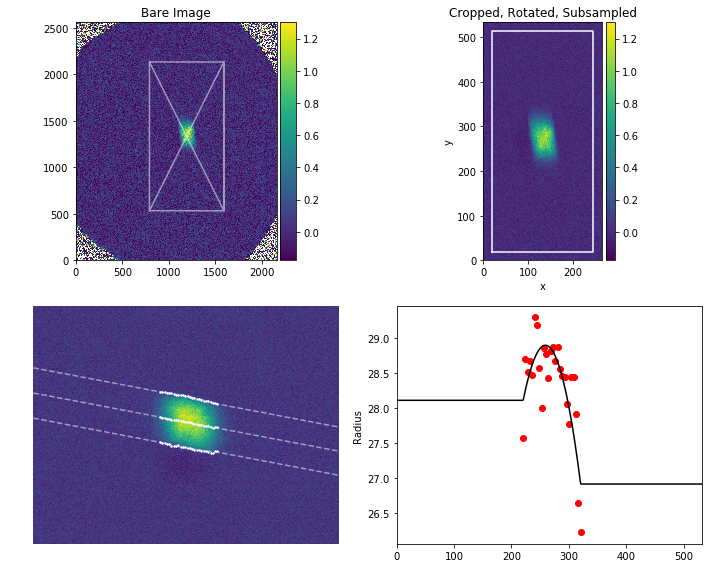

In [166]:
# Load Images 

# Load Images
# var = ['ExpansionTime','SideGreenEvap','WaitBox','IREvap','HeatTime','BoxShakeTime', 'ShakingCycles', 'BoxShakeAmp', 'BoxShakeFreq', 'Axial Grad Volt']
var = ['SideGreenEvap']
# x_var = 'BoxShakeFreq'
x_var = 'HeatCycles'
# x_var = 'ExpansionTime'
# x_var = 'Axial Grad Volt'
# x_var = 'ShakingCycles'
# x_var = 'SideGreenEvap'
df = get_from_clipboard(df=df, x_var = x_var, image_func=tp.Hybrid_Image, var=var, using=2, display=False)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1191, center_y = 1334, width = 800, height = 1600, fudge = 1.65)}
for i, r in df.iterrows(): r.image.set(**settings)

# Test
test = -1
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
# ax[2].plot(*df.image.iloc[test].nz.plotdata)
# ax[2].set(xlabel='z [um]', ylabel='Density n [um^-3]')
df.image.iloc[test].xsec.infoplot(axs = [ax[2],ax[3]])
plt.tight_layout()
plt.show()

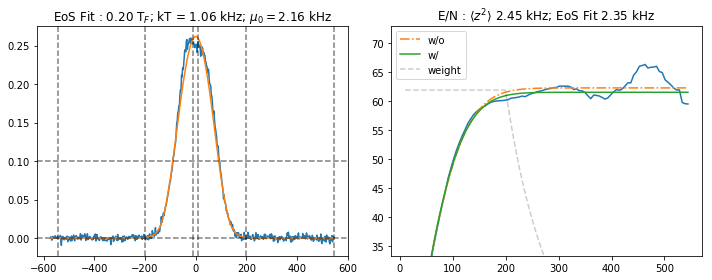

In [167]:
# Test Temperature Fits and Second Moment Limits 

zlim_second_moment = np.array([10, 200, df.image.iloc[0].nz.maxx*1e6])
kHz = 1e3 * cst.h
prefactor = 2 * cst.mass * df.image.iloc[0].trap_w**2

# Test function
def test_func(test=0, ):
    # Get the image and compute it all 
    im = df.image.iloc[test]
    im.T_kHz
    
    # Second moment
    nz = im.nz
    moment = compute_moment_v2(nz, zlim_second_moment)**0.5 * 1e6
    E_N_moment = prefactor * (moment*1e-6)**2 / kHz
    
    # Temperature
    Tfit_info = im.var['Tfit_info']
    nz_fit = tp.Curve(nz.x, Tfit_info[0](nz.x, *Tfit_info[1]), xscale=nz.xscale, yscale = nz.yscale)
    E_N_fit = hybrid_E_N(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f) / kHz
    
    # Plots
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].plot(*nz.plotdata)
    ax[0].plot(*nz_fit.plotdata)
    ax[0].axhline(im.Tfit_lim, linestyle='--', c='k', alpha=0.5)
    ax[0].axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [*zlim_second_moment, *-zlim_second_moment]: ax[0].axvline(_, linestyle='--',c='k',alpha=0.5)
    compute_moment_v2(nz, zlim_second_moment, plot=True, ax=ax[1])
    ax[0].set(title='EoS Fit : {:.2f} T$_F$; kT = {:.2f} kHz; $\mu_0=${:.2f} kHz'.format(im.TTF_center, im.T_kHz, im.mu0_kHz) )
    ax[1].set(title=r"E/N : $\left< z^2 \right>$ {:.2f} kHz; EoS Fit {:.2f} kHz".format(E_N_moment, E_N_fit))
    fig.tight_layout()

if df.shape[0] == 1:
    test_func(0)
else:
    ipywidgets.interact(test_func, test=(0, df.shape[0]-1, 1));

In [168]:
# Box Characteristics !!! CRUCIAL 

# Cross section for calculating EoS fit atom numebrs 
cross_section=np.pi*(63e-6)**2

# Box Volume for calculating E_F box 
box_volume = 94e-6 * cross_section 


        Total Loaded Images 2
        Atom Num Filter     2
        Removed Images      0
        


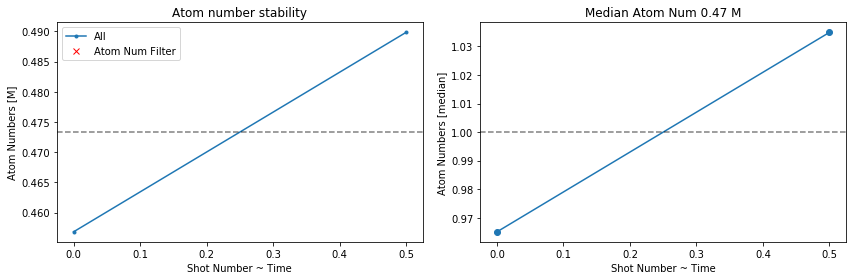

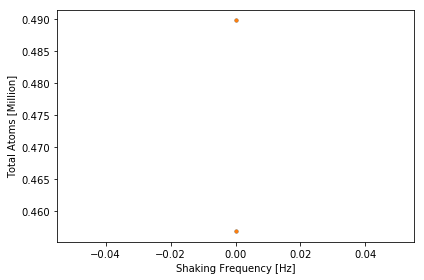

In [169]:
# fit and bin all data 

# Atom Number Filter
df['total_atoms'] = np.array([np.nansum(im.app) for im in tqdm(df.image, desc='Atoms')])
using = atom_num_filter(df, keep=0.2, offset=0.0)
plt.show()

# using = using & (df['ShakingCycles'].values != 0)
# print('Removed BG Images {}'.format(np.sum(using)))

# Compute E/N for good images
EN_eos = np.array([hybrid_E_N(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f) for im in tqdm(df.image[using], desc='EoS')])
EN_moment = np.array([prefactor * compute_moment_v2(im.nz, zlim_second_moment) for im in tqdm(df.image[using], desc='Moment')])
temp_eos_atoms = np.array([hybrid_total_atoms(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f, cross_section) for im in tqdm(df.image[using], desc='EoS')])

# Bin Data
EN_eos = bin_data(df.x.values[using], EN_eos)
EN_moment = bin_data(df.x.values[using], EN_moment)
total_atoms = bin_data(df.x.values[using], df.total_atoms.values[using])
total_atoms_fit = bin_data(df.x.values[using], temp_eos_atoms)

# Plot atoms vs x 
plt.figure()
plt.plot(df.x, df.total_atoms/1e6,'.')
plt.plot(df.x[using], df.total_atoms[using]/1e6,'.')
plt.xlabel('Shaking Frequency [Hz]')
plt.ylabel('Total Atoms [Million]')
plt.tight_layout()


In [170]:
# Information about the data 
unique, counts = np.unique(total_atoms[4], return_counts=True)
for i in range(unique.size):
    print(unique[i], '--', counts[i])

0.0 -- 2


### Plots 

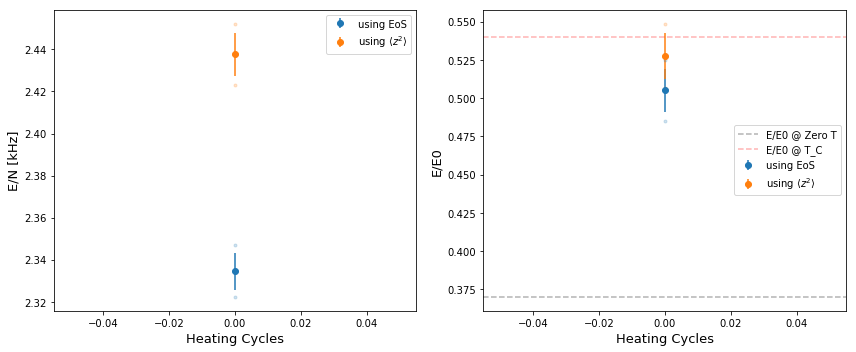

In [171]:
# Simple Plot : E/N and E/E0 vs x_variable 
# xlabel = 'Wait time [s]'
# xlabel = 'Freq [Hz]'
xlabel = 'Heating Cycles'
# xlabel = 'Expansion Time [ms]'
ylabel = 'E/N [kHz]'
fontsize = 13

plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.errorbar(EN_eos[0], EN_eos[1]/kHz, yerr=EN_eos[2]/kHz, fmt='oC0', label='using EoS')
plt.plot(EN_eos[4], EN_eos[5]/kHz, '.C0', alpha=0.2)
plt.errorbar(EN_moment[0], EN_moment[1]/kHz, yerr=EN_moment[2]/kHz, fmt='oC1', label = r'using $\left< z^2 \right>$')
plt.plot(EN_moment[4], EN_moment[5]/kHz, '.C1', alpha=0.2)
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()

plt.subplot(122)
E_E0 = 5/3 * EN_eos[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_eos = bin_data(EN_eos[4], E_E0)
plt.errorbar(*E_E0_eos[0:3], fmt='o', label='using EoS')
plt.plot(E_E0_eos[4], E_E0_eos[5], '.C0', alpha=0.2)
E_E0 = 5/3 * EN_moment[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_moment = bin_data(EN_moment[4], E_E0)
plt.errorbar(*E_E0_moment[0:3], fmt='o', label=r'using $\left< z^2 \right>$')
plt.plot(E_E0_moment[4], E_E0_moment[5], '.C1', alpha=0.2)
plt.axhline(0.37, linestyle='--', color='k', alpha=0.3, label='E/E0 @ Zero T')
plt.axhline(0.54, linestyle='--', color='r', alpha=0.3, label='E/E0 @ T_C')
plt.ylabel('E/E0', fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
# plt.xlim([0, None])
plt.legend()
plt.tight_layout()


In [172]:
# print some info 
test = 0
print(df.iloc[test].x)
print('Fudge : {}'.format(df.image.iloc[0].fudge))
print('Box Volume : {:.0f} um^3'.format(box_volume*1e18))
c = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
print("T/TF from EoS fit : {:.3f}".format(c(E_E0_eos[1][test])))
print('Atom Numbers : {:.3f} +- {:.3f} M'.format(np.mean(total_atoms_fit[5])/1e6, np.std(total_atoms_fit[5])/1e6))
print('Fermi Energy : {:.3f} +- {:.3f} kHz'.format(cst.n2EFHz(np.mean(total_atoms_fit[5])/box_volume)/1e3, np.std(cst.n2EFHz(np.array(total_atoms_fit[5])/box_volume)/1e3)))
print('Fermi Energy [test] : {:.3f}  kHz'.format(cst.n2EFHz(total_atoms_fit[1][test]/box_volume)/1e3))
print("E/N from EoS fit  : {:.3f} +- {:.3f}".format(EN_eos[1][test]/kHz, EN_eos[2][test]/kHz))
print("E/N from moment   : {:.3f} +- {:.3f}".format(EN_moment[1][test]/kHz, EN_moment[2][test]/kHz))
print("E/E0 from EoS fit : {:.3f} +- {:.3f}".format(E_E0_eos[1][test], E_E0_eos[2][test]))
print("E/E0 from moment  : {:.3f} +- {:.3f}".format(E_E0_moment[1][test], E_E0_moment[2][test]))

0.0
Fudge : 1.65
Box Volume : 1172084 um^3
T/TF from EoS fit : 0.155
Atom Numbers : 0.551 +- 0.028 M
Fermi Energy : 7.715 +- 0.263 kHz
Fermi Energy [test] : 7.715  kHz
E/N from EoS fit  : 2.334 +- 0.009
E/N from moment   : 2.438 +- 0.010
E/E0 from EoS fit : 0.505 +- 0.014
E/E0 from moment  : 0.527 +- 0.015


In [173]:
# Print more info
EF = cst.n2EF((total_atoms_fit[5])/box_volume)
vF = (2 * EF / cst.mass)**(1/2) * 1e3
xi = 0.37
zeroTLimit = (xi/3)**(1/2)
ctilde = (E_E0_eos[1][test]/3)**(1/2)
print('v_F = {:.3f} +/- {:.3f} [um/ms]'.format(np.mean(vF), np.std(vF)))
print('c (T=0) = {:.3f} +/- {:.3f} [um/ms]'.format(np.mean(vF)*zeroTLimit, np.std(vF)*zeroTLimit))
print('c (T) = {:.3f} +/- {:.3f} [um/ms]'.format(np.mean(vF)*(E_E0_eos[1][test]/3)**(1/2), np.std(vF)*(E_E0_eos[1][test]/3)**(1/2)))
print('c/v_F = {:.2f}'.format(ctilde))
print("Mean Atoms From Image {:.3f} +- {:.3f}".format(np.mean(df.loc[using, 'total_atoms'])/1e6, np.std(df.loc[using, 'total_atoms'])/1e6))

v_F = 31.984 +/- 0.546 [um/ms]
c (T=0) = 11.232 +/- 0.192 [um/ms]
c (T) = 13.125 +/- 0.224 [um/ms]
c/v_F = 0.41
Mean Atoms From Image 0.473 +- 0.017


In [174]:
# Subtract heating rate 
EE0_sub = 0.1
print("Subtracting {} from E/E0".format(EE0_sub))
print("=========================")
print("T/TF from EoS fit : {:.3f}".format(c(E_E0_eos[1][0] - EE0_sub)))
print('Fermi Energy : {:.3f} +- {:.3f} kHz'.format(cst.n2EFHz(np.mean(total_atoms_fit[5])/box_volume)/1e3, np.std(cst.n2EFHz(np.array(total_atoms_fit[5])/box_volume)/1e3)))
print("E/E0 from EoS fit : {:.3f} +- {:.3f}".format(E_E0_eos[1][0] - EE0_sub, E_E0_eos[2][0]))

EF = cst.n2EF((total_atoms_fit[5])/box_volume)
vF = (2 * EF / cst.mass)**(1/2) * 1e3
xi = 0.37
zeroTLimit = (xi/3)**(1/2)
ctilde = ((E_E0_eos[1][0] - EE0_sub)/3)**(1/2)
print('v_F = {:.3f} +/- {:.3f} [um/ms]'.format(np.mean(vF), np.std(vF)))
print('c (T=0) = {:.3f} +/- {:.3f} [um/ms]'.format(np.mean(vF)*zeroTLimit, np.std(vF)*zeroTLimit))
print('c (T) = {:.3f} +/- {:.3f} [um/ms]'.format(np.mean(vF)*((E_E0_eos[1][0] - EE0_sub)/3)**(1/2), np.std(vF)*((E_E0_eos[1][0] - EE0_sub)/3)**(1/2)))
print('c/v_F = {:.2f}'.format(ctilde))

Subtracting 0.1 from E/E0
T/TF from EoS fit : 0.116
Fermi Energy : 7.715 +- 0.263 kHz
E/E0 from EoS fit : 0.405 +- 0.014
v_F = 31.984 +/- 0.546 [um/ms]
c (T=0) = 11.232 +/- 0.192 [um/ms]
c (T) = 11.754 +/- 0.201 [um/ms]
c/v_F = 0.37


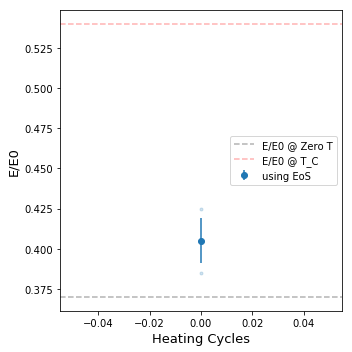

In [175]:
# Simple Plot : E/N and E/E0 vs x_variable 
# xlabel = 'Wait time [s]'
# xlabel = 'Freq [Hz]'
xlabel = 'Heating Cycles'
# xlabel = 'Expansion Time [ms]'
ylabel = 'E/N [kHz]'
fontsize = 13

plt.figure(figsize=[5, 5])

E_E0 = 5/3 * EN_eos[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_eos = bin_data(EN_eos[4], E_E0)
plt.errorbar(E_E0_eos[0],E_E0_eos[1] - EE0_sub,E_E0_eos[2], fmt='o', label='using EoS')
plt.plot(E_E0_eos[4], E_E0_eos[5] - EE0_sub, '.C0', alpha=0.2)
plt.axhline(0.37, linestyle='--', color='k', alpha=0.3, label='E/E0 @ Zero T')
plt.axhline(0.54, linestyle='--', color='r', alpha=0.3, label='E/E0 @ T_C')
plt.ylabel('E/E0', fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
# plt.xlim([0, None])
plt.legend()
plt.tight_layout()


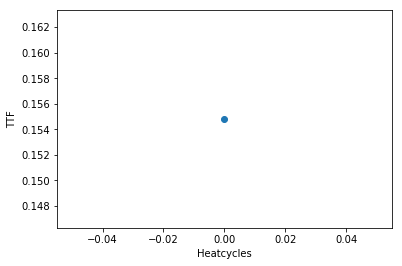

In [176]:
plt.plot(E_E0_eos[0][:],c(E_E0_eos[1][:]),'o')
plt.xlabel('Heatcycles')
plt.ylabel('TTF')
plt.show()

### Plots for Difference between Two Points

In [103]:
# EN_eos
# E_E0_eos
dEN_eos = [(EN_eos[1][1] - EN_eos[1][0]) / kHz, (EN_eos[2][1]**2 + EN_eos[2][0]**2)**(1/2) / kHz]
dE_E0_eos = [E_E0_eos[1][1] - E_E0_eos[1][0], (E_E0_eos[2][1]**2 + E_E0_eos[2][0]**2)**(1/2)]

print("Delta E/N  \t{:.4f} +- {:.4f} kHz".format(*dEN_eos))
print("Delta E/E0 \t{:.4f} +- {:.4f}".format(*dE_E0_eos))

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
plt.plot(df.x, [im.trap_center for im in df.image], 'o')

### Store/Copy Data

In [ ]:
# # Copy data to clipboard for pasting in excel
cols = ['Freq', 'total_atoms', 'EN_eos', 'EN_moment', 'EF']
data = np.array([total_atoms[4], total_atoms[5], EN_eos[5], EN_moment[5], cst.n2EF(total_atoms[5] / box_volume)]).T
index = df.name[using].tolist()
paste = pd.DataFrame(data, columns=cols, index=index).to_clipboard(excel=True,)

In [ ]:
# Copy information to clipboard 
c = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
data = ['Fudge', df.image.iloc[0].fudge, 'Volume', box_volume, 'TTF', c(E_E0_eos[1][0]), 
        'EN_EoS', EN_eos[1][0]/kHz, 'EN_EoS_Err', EN_eos[2][0]/kHz, 
        'EN_moment', EN_moment[1][0]/kHz, 'EN_moment_Err', EN_moment[2][0]/kHz, 
        'EE0_EoS', E_E0_eos[1][0], 'EE0_EoS_Err', E_E0_eos[2][0], 
        'EE0_moment', E_E0_moment[1][0], 'EE0_moment_Err', E_E0_moment[2][0], ]
paste = pd.DataFrame(data).to_clipboard(excel=True, header=False, index=False)

### Tests

* Does Gaussian fit always give the second moment? Check with simulated densities. NO!!
* Effect of zlim for second moment
* Does second moment change with the fudge? It shouldn't!

In [ ]:
# Simulated Densities : Gaussian Fits and Second Moment 
kT = 0.1e3 * cst.h
mu = 3.0e3 * cst.h
trapf=23.35

def test_func(kT = 100, mu = 3000, noise_frac = 100, noise = False, show=False):
    kT *= cst.h
    mu *= cst.h
    z = df.image.iloc[0].nz.x
    n = UFG.density_hybrid(z, kT, mu, trapf)
    if noise:
        n += np.random.normal(scale=n.max()/noise_frac, size=n.size)
    nz = tp.Curve(z, n, xscale=1e-6, yscale=1e18)

    E_N_0 = hybrid_E_N(kT, mu, trapf=trapf, simple=False)/cst.h
    if show: print('\nEquation of State : E/N {:.0f} Hz'.format(E_N_0))

    if show: print('\nGaussian Fits')
    Gsize, Gres = gaussian_fit_sigma(nz, plot=False)
    GE_N = 2 * cst.mass * (cst.twopi*trapf)**2 * Gsize**2 / cst.h
    Gerr = (GE_N-E_N_0)/E_N_0*100
    if show: print('\tsize {:.2f} us'.format(Gsize * 1e6))
    if show: print('\tE/N {:.0f} Hz'.format(GE_N))
    if show: print('\t% Diff {:.1f}'.format(Gerr))

    if show: print('\nSecond Moment')
    Msize = compute_moment(nz, nz.maxx*1e6)**0.5
    ME_N = 2 * cst.mass * (cst.twopi*trapf)**2 * Msize**2 / cst.h
    Merr = (ME_N-E_N_0)/E_N_0*100
    if show: print('\tsize {:.2f} us'.format(Msize * 1e6))
    if show: print('\tE/N {:.0f} Hz'.format(ME_N))
    if show: print('\t% Diff {:.1f}'.format(Merr))

    if show: plt.plot(*nz.plotdata, label='Generated Density')
    if show: plt.plot(nz.xyfitplot[0]*1e6, nz.xyfitplot[1]/1e18, label='Gaussian Fit')
    if show: plt.legend()
    if show: plt.show()
        
    if not show: return [Merr, Gerr, Gres]

# # Interactive Widget
ipywidgets.interact(test_func, kT=(100, 7000, 100), mu=(100, 10000, 100), noise_frac=(10, 200, 10));

# # Gaussian Error vs residual 
# mu = 3e3
# kT = np.linspace(100, 7000, 100)
# res = []
# for kT_ in tqdm(kT):
#     res.append(temp_func(kT_, mu))
# res = np.array(res)
# plt.plot(kT, res[:, 1])

In [ ]:
# Second Moment and zlim for real data 

zlims = np.linspace(200, df.image.iloc[0].nz.maxx*1e6, 100)
def test_func(test=0, fudge=1.0):
    nz = df.image.iloc[test].nz
    nz = tp.Curve(nz.x, nz.y*fudge, xscale=nz.xscale, yscale=nz.yscale)
    moment = np.array([compute_moment(nz, zlim=z) for z in zlims])**0.5 * 1e6

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(*nz.plotdata)
    plt.title('Experimental Data')
    plt.axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [zlims[0], -zlims[0], zlims[-1], -zlims[-1]]:
        plt.axvline(_, linestyle='--',c='k',alpha=0.5)
    plt.subplot(122)
    plt.plot(zlims, moment)

ipywidgets.interact(test_func, test=(0, df.shape[0]-1, 1), fudge=(0.2,4,0.2));

In [ ]:
# Second Moment and zlim for simulated data 

def test_func(kT = 100, mu = 3000, noise_frac = 100):
    kT *= cst.h
    mu *= cst.h
    z = df.image.iloc[0].nz.x
    n0 = UFG.density_hybrid(z, kT, mu, trapf)
    n = n0 + np.random.normal(scale=n0.max()/noise_frac, size=n0.size)
    nz0 = tp.Curve(z, n0, xscale=1e-6, yscale=1e18)
    nz = tp.Curve(z, n, xscale=1e-6, yscale=1e18)
    
    zlims = np.linspace(200, df.image.iloc[0].nz.maxx*1e6, 100)
    moment0 = compute_moment(nz0, zlim=zlims[-1])**0.5 * 1e6
    moment = np.array([compute_moment(nz, zlim=z) for z in zlims])**0.5 * 1e6

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(*nz.plotdata)
    plt.title('Simulated Data + Gaussian Noise')
    plt.axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [zlims[0], -zlims[0], zlims[-1], -zlims[-1]]:
        plt.axvline(_, linestyle='--',c='k',alpha=0.5)
    plt.subplot(122)
    plt.plot(zlims, moment)
    plt.axhline(moment0, linestyle='--', c='k', alpha=0.5)

ipywidgets.interact(test_func, kT=(100, 7000, 100), mu=(100, 10000, 100), noise_frac=(10, 200, 10));

In [ ]:
# Second Moment ver 2 and zlim for simulated data 

cutoff = np.array([10, 300, df.image.iloc[0].nz.maxx*1e6])
def test_func(kT=500, mu=3000, noise_frac=50, ):
    kT *= cst.h
    mu *= cst.h
    z = df.image.iloc[0].nz.x
    n0 = UFG.density_hybrid(z, kT, mu, trapf)
    n = n0 + np.random.normal(scale=n0.max()/noise_frac, size=n0.size)
    nz0 = tp.Curve(z, n0, xscale=1e-6, yscale=1e18)
    nz = tp.Curve(z, n, xscale=1e-6, yscale=1e18)
    
    moment0 = compute_moment(nz0, zlim=zlims[-1])**0.5 * 1e6
    moment = compute_moment_v2(nz, cutoff)**0.5 * 1e6

    print("True Size {:.2f} um".format(moment0))
    print("Calc Size {:.2f} um".format(moment))
    print("Fractional Error {:.2f} %".format((moment-moment0)/moment0*100))

    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].plot(*nz.plotdata)
    ax[0].axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [*cutoff, *-cutoff]:
        ax[0].axvline(_, linestyle='--',c='k',alpha=0.5)
    compute_moment_v2(nz, cutoff, plot=True, ax=ax[1])
    ax[1].axhline(moment0, linestyle='--', c='r', alpha=0.5, label='True Value')
    ax[1].legend()
    ax[0].set(title='Simulated Data + Gaussian Noise')
    fig.tight_layout()

ipywidgets.interact(test_func, kT=(100, 7000, 100), mu=(100, 10000, 100), noise_frac=(10, 200, 10));

In [ ]:
# Second Moment ver 2 and zlim for experimental data 

cutoff = np.array([10, 300, df.image.iloc[0].nz.maxx*1e6])
def test_func(test=0, ):
    nz = df.image.iloc[test].nz
    moment = compute_moment_v2(nz, cutoff)**0.5 * 1e6

    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].plot(*nz.plotdata)
    ax[0].axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [*cutoff, *-cutoff]:
        ax[0].axvline(_, linestyle='--',c='k',alpha=0.5)
    compute_moment_v2(nz, cutoff, plot=True, ax=ax[1])
    ax[0].set(title='Experimental Data')
    fig.tight_layout()

ipywidgets.interact(test_func, test=(0, df.shape[0]-1, 1),);

## Sliced Hybrid -- very hacky

In [ ]:
# Used Function 

def find_rescaling_simple_lstsq(A, B, cutoff=2000):
    A = A[B < cutoff]
    B = B[B < cutoff]
    def fitfun(x, amp): return B / amp
    c = tp.Curve(y = A)
    fr, fe = c.fit(fitfun, [1,])
    return (fr[0], fe[0])

def erf0(x, x0, sigma, amp=1):
    return -(erf(x, x0, sigma, amp) - 1)/2

def find_rescaling_erf_lstsq(A, B, cutoff=2000, width=200):
    A = A * erf0(B, cutoff, width)
    B = B * erf0(B, cutoff, width)
    def fitfun(x, amp): return B / amp
    c = tp.Curve(y = A)
    fr, fe = c.fit(fitfun, [1,])
    return (fr[0], fe[0])

def find_rescaling_i(i, df, cutoff=2000, width=200):
    A = np.sum(df.image.iloc[i+0].app, axis=1)
    B = np.sum(df.image.iloc[i+1].app, axis=1)
    return find_rescaling_erf_lstsq(A, B, cutoff, width)

In [ ]:
# Load Images 

# Load Images
var = ['IREvap', 'SideGreenEvap', 'HeatWait', 'SlicerPower', 'SliceTime', 'SideGreenReramp', 'SideGreenPower','TopGreenPower','ImgPower1','ImgPower2']
x_var = 'SideGreenEvap'
df = get_from_clipboard(x_var = x_var, image_func=tp.Hybrid_Image, var=var, using=2, display=False)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1117, center_y = 1290, width = 600, height = 1200)}
for i, r in df.iterrows(): r.image.set(**settings)

# Test
test = 1
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
df.image.iloc[test].xsec.infoplot(axs = [ax[2],ax[3]])
plt.tight_layout()
plt.show()

In [ ]:
# Things that are changing
# SideGreenEvap, IREvap, HeatWait, 
# df

### Specific Specialized Analysis

In [ ]:
# # Atom Numeber differences between TopA and TopB 
# total_atoms = np.array([im.total_atoms for im in tqdm(df.image)])
# imbalance = (total_atoms[::2] - total_atoms[1::2]) / (total_atoms[::2] + total_atoms[1::2])

# data = pd.DataFrame(dict(SideGreenEvap = df.SideGreenEvap.values[::2], 
#                          IREvap = df.IREvap.values[::2], 
#                          HeatWait = df.HeatWait.values[::2], 
#                          total_atoms = total_atoms[::2] + total_atoms[1::2], 
#                          imbalance=imbalance))
# uSGE = np.unique(data.SideGreenEvap)
# uIR = np.unique(data.IREvap)
# uHW = np.unique(data.HeatWait)
# print('Unique SideGreenEvap \t', uSGE)
# print('Unique IREvap \t\t', uIR)
# print('Unique HeatWait \t', uHW)


# # Plots vs IREvap for diff settings 
# for u in uSGE:
#     d = data[data.SideGreenEvap == u]
#     plt.plot(d.IREvap, d.imbalance, 'o', label='SGE = {}'.format(u))
# plt.legend()
# plt.axhline(0, linestyle='--', c='k')
# plt.xlabel('IR Evap')
# plt.ylabel('Imbalance')
# plt.title('Scatter in Imbalance')
# plt.tight_layout()
# plt.show()

In [ ]:
# Scaling factor vs various things 
total_atoms = np.array([im.total_atoms for im in tqdm(df.image)])
scaling_factor = np.array([find_rescaling_erf_lstsq(np.sum(imA.app, axis=1), np.sum(imB.app, axis=1), cutoff=3500, width=300)[0] for (imA, imB) in zip(df.image.iloc[0::2], df.image.iloc[1::2])])

data = pd.DataFrame(dict(SideGreenEvap = df.SideGreenEvap.values[::2], 
                         IREvap = df.IREvap.values[::2], 
                         HeatWait = df.HeatWait.values[::2], 
                         total_atoms = total_atoms[::2] + total_atoms[1::2], 
                         scaling_factor=scaling_factor))
uSGE = np.unique(data.SideGreenEvap)
uIR = np.unique(data.IREvap)
uHW = np.unique(data.HeatWait)
print('Unique SideGreenEvap \t', uSGE)
print('Unique IREvap \t\t', uIR)
print('Unique HeatWait \t', uHW)


# Plots vs IREvap for diff settings 
for u in uSGE:
    d = data[data.SideGreenEvap == u]
    plt.plot(d.IREvap, d.scaling_factor, 'o', label='SGE = {}'.format(u))
plt.legend()
plt.xlabel('IR Evap')
plt.ylabel('Scaling Factor')
plt.title('Scaling Factor for Slicing')
plt.tight_layout()
plt.show()

In [ ]:
# EoS fit 
# fudge = 2.3
# fudge = 2
fudge = 3
test = 8 *2
rescaling_factor = find_rescaling_i(test, df, cutoff=3500, width=300)[0]

# Prepare Image B
imB = tp.Hybrid_Image(df.image.iloc[test+1].name, **settings)
imB.set(fudge = fudge)
imB.plot_hybrid_temp_info()

# Prepare Image A
imA = tp.Hybrid_Image(df.image.iloc[test+0].name, xsec_override=imB.xsec, trap_center_override=imB.trap_center, **settings)
imA.set(fudge = fudge * rescaling_factor * 0.95, radial_selection = 0.5)
imA.plot_hybrid_temp_info()


### Tests

In [ ]:
# Simple rescaling factor -- Doesn't work so great 
def test_func(test = 0, cutoff = 2000, ):
    A = np.sum(df.image.iloc[test+0].app, axis=1)
    B = np.sum(df.image.iloc[test+1].app, axis=1)
    rescaling_factor = B[B<cutoff].sum() / A[B<cutoff].sum()
    plt.plot(A*rescaling_factor)
    plt.plot(B)
    plt.plot(A, '--')
    plt.axhline(cutoff, c='k', linestyle='--', )
    plt.title('Rescaling Factor {:.2f}'.format(rescaling_factor))
    plt.show()
ipywidgets.interact(test_func, test=(0, df.shape[0]-2, 2), cutoff=(500, 6000, 100));

In [ ]:
# Minimizing sum of diff. square  
test = 0
cutoff = 2000
def test_func(test = 0, cutoff = 2000, ):
    A = np.sum(df.image.iloc[test+0].app, axis=1)
    B = np.sum(df.image.iloc[test+1].app, axis=1)
    rescaling_factor = find_rescaling_simple_lstsq(A, B, cutoff)[0]
    plt.plot(A*rescaling_factor, label='Rescaled S1')
    plt.plot(B, label='S3')
    plt.plot(A, '--', label='Sliced S1')
    plt.axhline(cutoff, c='k', linestyle='--', )
    plt.title('Rescaling Factor {:.2f}'.format(rescaling_factor))
    plt.legend()
    plt.show()

ipywidgets.interact(test_func, test=(0, df.shape[0]-2, 2), cutoff=(500, 6000, 100));


In [ ]:
# Minimizing sum of diff. square with error function cutoff 
test = 0
cutoff = 2000
width = 200

A = np.sum(df.image.iloc[test+0].app, axis=1)
B = np.sum(df.image.iloc[test+1].app, axis=1)

def test_func(test = 0, cutoff = 2000, width = 100):
    A = np.sum(df.image.iloc[test+0].app, axis=1)
    B = np.sum(df.image.iloc[test+1].app, axis=1)
    rescaling_factor = find_rescaling_erf_lstsq(A, B, cutoff, width)[0]
    plt.plot(A*rescaling_factor, label='Rescaled S1')
    plt.plot(B, label = 'Reference S3')
    plt.plot(A, '--', label='Sliced S1')
    plt.legend()
    plt.axhline(cutoff, c='k', linestyle='--', )
    plt.title('Rescaling Factor {:.2f}'.format(rescaling_factor))
    plt.show()

ipywidgets.interact(test_func, test=(0, df.shape[0]-2, 2), cutoff=(500, 6000, 100), width=(50, 1000, 50));



In [ ]:
# cutoff vs scaling 


# Momentum Distribution

## Ideal Fermi Gas

## Unitary Fermi Gas

## Density Calibration using Fermi-Dirac

# Rapid Ramp

## Top Rapid Ramp Angle

Daily Calculations v2

## Condensate Fraction - Top Focused Rapid Ramp 

In [710]:
# Function definition for cond frac 
def get_cond_frac(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    fr = c_.fit(gaussian, [c_.maxx/2, c_.maxx/8, c_.maxy, c_.maxy/1000], plot=False)[0]
    x, y = c.x, c.y - fr[3]
    fr[3] = 0
    xf, yf = x, gaussian(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(app)
        plt.axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        plt.axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        plt.subplot(122)
        plt.plot(*c.plotdata)
        plt.plot(*c_.xyfitplot)
        plt.axvline(thermal_limits[0], color='r', linestyle='--', alpha=0.3)
        plt.axvline(thermal_limits[1], color='r', linestyle='--', alpha=0.3)
        plt.xlim([fr[0] - plot_width, fr[0] + plot_width])
        plt.tight_layout()

    return cond_frac, fr[1]

# Function definition for cond frac 
def get_cond_frac(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    fr = c_.fit(gaussian, [c_.maxx/2, c_.maxx/8, c_.maxy, c_.maxy/1000], plot=False)[0]
    x, y = c.x, c.y - fr[3]
    fr[3] = 0
    xf, yf = x, gaussian(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(app)
        plt.axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        plt.axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        plt.subplot(122)
        plt.title(r'Gaussian Thermal Fit $N_c=${:.2f}'.format(cond_frac))
        plt.plot(*c.plotdata)
        plt.plot(*c_.xyfitplot)
        plt.axvline(thermal_limits[0], color='r', linestyle='--', alpha=0.3)
        plt.axvline(thermal_limits[1], color='r', linestyle='--', alpha=0.3)
        plt.xlim([fr[0] - plot_width, fr[0] + plot_width])
        plt.tight_layout()

    return cond_frac, fr[1]

def g_3half_fitfun(x, x0, mu, kt, n0, offset=0):
    return (1/(2*np.pi*kt)**(3/2))*n0* mpmath.fp.polylog(3/2,np.exp(-np.abs(((x-x0)**2)/2 + np.abs(mu))/kt )) + offset

g32 = np.vectorize(g_3half_fitfun)

def get_cond_frac_polylog(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    fr = c_.fit(g32, [c_.maxx/2, 0.1, 1e3, 4e8,0], plot=False)[0]
    x, y = c.x, c.y - fr[4]
    fr[4] = 0
    xf, yf = x, g32(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(app)
        plt.axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        plt.axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        plt.subplot(122)
        plt.title(r'Polylog Thermal Fit $N_c=${:.2f}'.format(cond_frac))
        plt.plot(*c.plotdata)
        plt.plot(*c_.xyfitplot)
        plt.axvline(thermal_limits[0], color='r', linestyle='--', alpha=0.3)
        plt.axvline(thermal_limits[1], color='r', linestyle='--', alpha=0.3)
        plt.xlim([fr[0] - plot_width, fr[0] + plot_width])
        plt.tight_layout()

    return cond_frac, fr[2]

def get_cond_frac_mixed(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    
    # first fit a gaussian
    fr = c_.fit(gaussian, [c_.maxx/2, c_.maxx/8, c_.maxy, c_.maxy/1000], plot=False)[0]
    x, y = c.x, c.y - fr[3]
    fr[3] = 0
    xf, yf = x, gaussian(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    fit_method = 'Gaussian'
    Tstar = fr[1]
    c_fit = c_
    
    # if it's narrow enough, fit a polylog
    if fr[1] <= 39:
        c_p = tp.Curve(x = c.x[using], y = c.y[using])
        fr = c_p.fit(g32, [c_p.maxx/2, 1e3, 1e3, 5e8,0], plot=False)[0]
        x, y = c.x, c.y - fr[4]
        fr[4] = 0
        xf, yf = x, g32(x, *fr)
        cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
        fit_method = 'PolyLog'
        Tstar = fr[2]
        c_fit = c_p
        
    if cond_frac>0.3:
        # expand thermal limits for large condensates
        thermal_limits = np.array(thermal_limits)+[-5,5]
        using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
        c_p = tp.Curve(x = c.x[using], y = c.y[using])
        fr = c_p.fit(g32, [c_p.maxx/2,1e3, 1e3, 5e8,0], plot=False)[0]
        x, y = c.x, c.y - fr[4]
        fr[4] = 0
        xf, yf = x, g32(x, *fr)
        cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
        fit_method = 'PolyLog'
        Tstar = fr[2]
        c_fit = c_p
        

    
    if plot:
        fig, axarr = plt.subplots(ncols=2, figsize=(10,4))
        axarr[0].imshow(app)
        axarr[0].axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        axarr[0].axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        axarr[0].set_title('Raw Rapid Ramp')
        
        axarr[1].set(title=r'$N_c=${:.2f}'.format(cond_frac), xlim=[fr[0] - plot_width, fr[0] + plot_width])
        axarr[1].plot(*c.plotdata,'r-', linewidth=2, alpha=0.6, label='data')
        axarr[1].plot(*c_.xyfitplot, 'k--', alpha=0.5, linewidth=1 , label='Gaussian thermal fit')
        if fit_method=='PolyLog':
            axarr[1].plot(*c_p.xyfitplot, 'k-', linewidth=1 , label='Polylog thermal fit')
            
        axarr[1].axvspan(*thermal_limits, alpha=0.05, color='k', label='Excluded from fit')
        plt.legend()
        plt.tight_layout()
        
    
        
    return cond_frac, Tstar, c_fit, c



Updating the local database...
Done


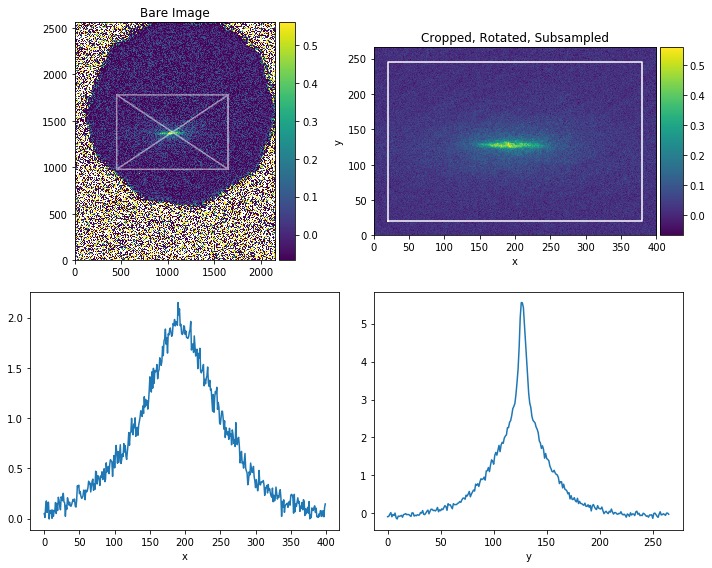

In [717]:
# Load Images 

# Load Images
var = ['IREvap', 'SideGreenEvap', 'HeatWait', 'ShakingCycles']
x_var = 'HeatCycles'
# x_var = 'SideGreenEvap'
df = get_from_clipboard(x_var = x_var, var=var, using=0, display=False)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1053, center_y = 1380, width = 1200, height = 800, 
                   rotate = 4)}
for i, r in df.iterrows(): r.image.set(**settings)

# Test
test = 0
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
ax[2].plot(np.nanmean(df.image.iloc[test].app, axis=0))
ax[3].plot(np.nanmean(df.image.iloc[test].app, axis=1))
ax[2].set(xlabel='x')
ax[3].set(xlabel='y')
plt.tight_layout()
plt.show()

# Total Atoms
df['total_atoms'] = np.array([np.nansum(im.app) for im in tqdm(df.image, desc='Atoms')])

In [718]:
# Condensate Fraction sampler 
cond_frac_center = df.image.iloc[0].app.shape[0]//2-5
width = 10
plot_width = 70
thermal_limits = [cond_frac_center - width, cond_frac_center + width]

def temp_func(test = 0):
#     cond_frac, sigma = get_cond_frac(df.image.iloc[test].app, thermal_limits, True, plot_width)
    cond_frac, Tstar, c_fit, c = get_cond_frac_mixed(df.image.iloc[test].app, thermal_limits, True, plot_width)
    print('Condensate Fraction {:.2f} for x_var {}'.format(cond_frac, df.x.iloc[test]))
if df.shape[0]==1:
    temp_func(0)
else:
    ipywidgets.interact(temp_func, test=(0, df.shape[0]-1, 1));

interactive(children=(IntSlider(value=0, description='test', max=4), Output()), _dom_classes=('widget-interact…

In [719]:
# fit and bin all data 

# Fit for cond frac 
fit_results = [get_cond_frac_mixed(im.app, thermal_limits) for im in df.image]
fit_results = np.array(fit_results)
df['cond_frac'] = fit_results[:,0] 
df['sigma'] = fit_results[:, 1] * df.image.iloc[0].pixel_binned * 1e6 # in um

# bin cond fraction -- binned data ==> [0:x, 1:y_mean, 2:y_err, 3:y, 4:x_all, 5:y_all]
cond_frac_binned = bin_data(df.x.values, df.cond_frac.values)
Tstar_binned = bin_data(df.x.values, df.sigma.values**2 / 1000)
total_atoms_binned = bin_data(df.x.values, df.total_atoms.values/1e6)

### Plots

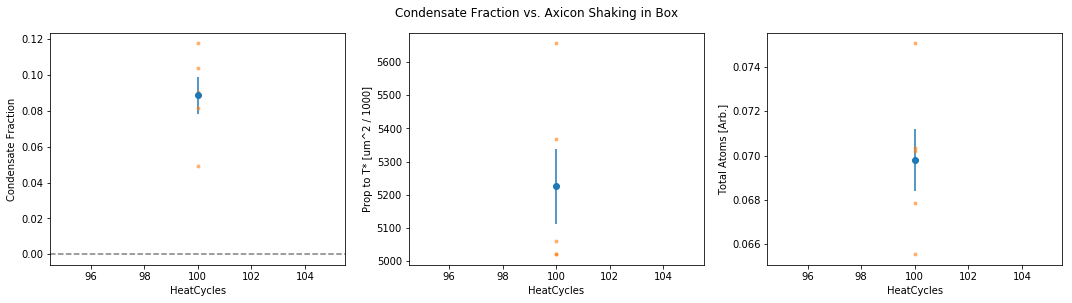

In [720]:
# Simple Plot : {Cond Frac, T*, Atom #} vs x 

# User input
subplot, figsize = 130, (15, 4)
# subplot, figsize = 310, (5, 10)
suptitle = 'Condensate Fraction vs. Axicon Shaking in Box'
# xlabel = 'Heat Wait [s]'
# xlabel = 'Axicon Shaking Cycles'
xlabel = x_var
xlim = [None, None]

# Plotter
plt.figure(figsize=figsize)

plt.subplot(subplot+1)
plt.errorbar(*cond_frac_binned[0:2], yerr = cond_frac_binned[2], fmt='o')
plt.plot(*cond_frac_binned[4:6], '.', alpha=0.5)
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.xlim(xlim)
plt.xlabel(xlabel)
plt.ylabel('Condensate Fraction')

plt.subplot(subplot+2)
plt.errorbar(*Tstar_binned[0:2], yerr = Tstar_binned[2], fmt='o')
plt.plot(*Tstar_binned[4:6], '.', alpha=0.5)
plt.xlim(xlim)
plt.xlabel(xlabel)
plt.ylabel('Prop to T* [um^2 / 1000]')

plt.subplot(subplot+3)
plt.errorbar(*total_atoms_binned[0:2], yerr = total_atoms_binned[2], fmt='o')
plt.plot(*total_atoms_binned[4:6], '.', alpha=0.5)
plt.xlim(xlim)
plt.xlabel(xlabel)
plt.ylabel('Total Atoms [Arb.]')

plt.suptitle(suptitle, y=1.04)
plt.tight_layout()

In [721]:
# Cond frac and std 
Condfrac=cond_frac_binned[4:6][1]
CondfracMean=np.mean(Condfrac)
CondfracStd=np.std(Condfrac)

print('The Condensate fraction: {:.3f} +/- {:.3f}'.format(CondfracMean,CondfracStd))

The Condensate fraction: 0.089 +/- 0.023


In [722]:
cond_frac_binned[0]

array([100.])

## Side Rapid Ramp long TOF counting

In [286]:
# Entire Code Here 

print("\n============== LOADING IMAGES ==============")
# Initialize Dataframe
df = get_from_clipboard(init=True)
var = ['HeatCycles']
x_var = 'HeatCycles'

df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)

# If ImagFreq0 is no good, use ImagFreq1
# x_var = 'ImagFreq1'
# df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)

print("Total Images {}".format(df.shape[0]))
plt.show()

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 121, center_y = 63, width=100, height=100, 
                   subsample=1, od_method='log', bg_width=10)}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)



============== LOADING IMAGES ==============



Updating the local database...
Done
Total Images 2


In [287]:
df.x

0    0.0
1    0.0
Name: x, dtype: float64

In [288]:

# Tests
print("\n============== Testing Crop Settings ==============")
test = 6

print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

# ROI
print("\n============== Testing Region Of Interest ==============")
center_offset = [0, 0]
width, height = 20, 20
roi = tp.imagedata.get_cropi(df.image.iloc[test].od, 
                             center=(df.image.iloc[test].od.shape[1]//2 + center_offset[1], df.image.iloc[test].od.shape[0]//2 + center_offset[0]), 
                             width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()



============== Testing Crop Settings ==============


IndexError: single positional indexer is out-of-bounds

In [ ]:
# Fitting
print("\n============== Condensate number ==============")
def imsum(od):
    od = od[roi]
    od = od[np.abs(od) < 10000]
    return np.nansum(od)
df['total_atoms'] = np.array([imsum(im.od) for im in df.image])
c = tp.Curve(x = np.array(df.x), y = np.array(df.total_atoms))
c.removenan() 
plt.plot(*c.plotdata,'o')
plt.xlabel('Heat Cycles')
plt.ylabel('Condensate N [a.u.]')
plt.show()
# res_curve = tp.Curve(x = c.x, y = c.y/c.y.max()).sortbyx() 
# guess = [res_curve.x.mean(), 3, 1, 0] 
# fitres, fiterr = res_curve.fit(lorentian_fitfun, guess, 
#                        plot=True)
# plt.show()

# Animation

## Animation - Images with Labels Only

## Animation - Curves

## Animation

# Uncategorized

## Density Difference : TopA - TopB

## Imaging Intensity vs Volt

## Maximum Absorption

## Slit Sharpness

In [251]:
# One Time Setup 
df = get_from_clipboard(init=True)


Updating the local database...
Done


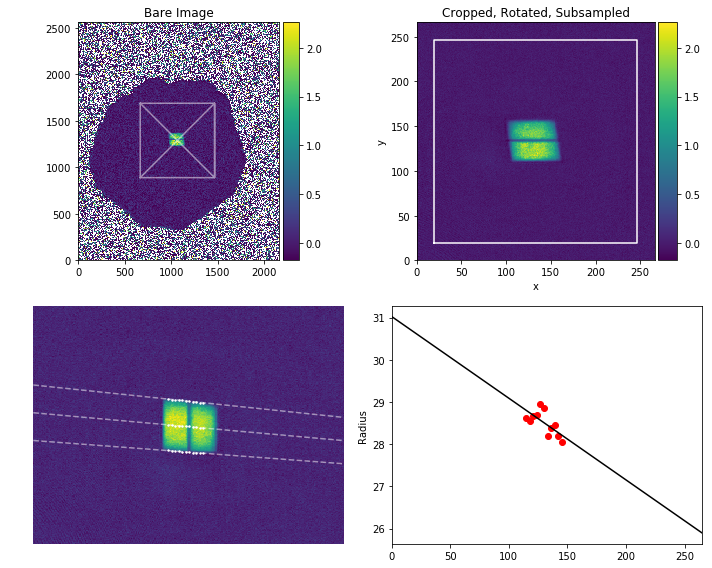

In [284]:
# Load Images 

# Load Images
var = ['ExpansionTime','SideGreenEvap','WaitBox','IREvap','HeatTime','BoxShakeTime', 'ShakingCycles', 'BoxShakeAmp', 'BoxShakeFreq', 'Axial Grad Volt']
var = ['SideGreenEvap']
x_var = 'BoxShakeFreq'
df = get_from_clipboard(df=df, x_var = x_var, image_func=tp.Hybrid_Image, var=var, using=0, display=False)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1066, center_y = 1290, width = 800, height = 800, fudge = 1, subsample=3, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.1, radial_selection=0.9)}
for i, r in df.iterrows(): r.image.set(**settings)

# Test
test = -1
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
df.image.iloc[test].xsec.infoplot(axs = [ax[2],ax[3]])
plt.tight_layout()
plt.show()

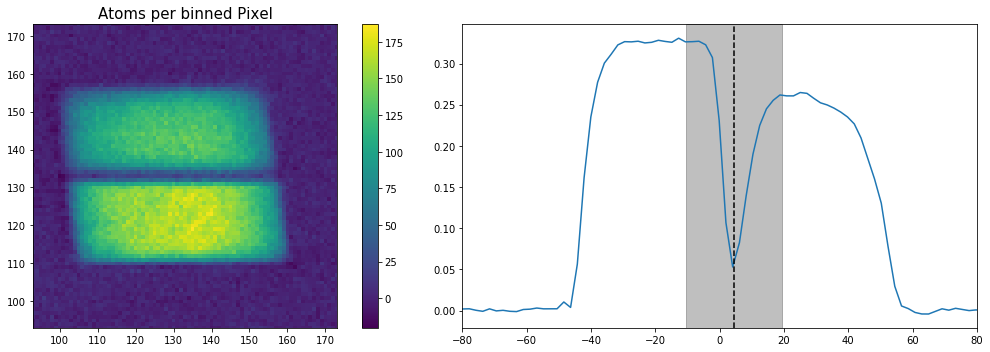

In [285]:
# Sample n(z) 
df['nz'] = [im.nz for im in tqdm(df.image)]

center = 4.5
width = 15
size = 80
def temp(test=np.random.randint(df.shape[0])):
    r = df.iloc[test]
    roi = tp.get_roi(r.image.app, width=size, height=size)
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plt.sca(ax[0])
    plt.imshow(r.image.app)
    plt.colorbar()
    plt.title('Atoms per binned Pixel', fontsize=15)
    ax[0].set(xlim=[roi[1].start, roi[1].stop], ylim=[roi[0].start, roi[0].stop])
    ax[1].plot(*r.nz.plotdata)
    ax[1].axvline(center, color='k', linestyle='--')
    ax[1].axvspan(center-width, center+width, color='k', alpha=0.25)
    ax[1].set(xlim=[-size, size])
    plt.tight_layout()
if df.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df.shape[0]-1))

        FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
x0      3.920781  0.287599  None    4.5        -inf         inf   7.335255
sep     3.008130  0.321935  None    4.0        -inf         inf  10.702169
sigma1  2.080271  0.096954  None    2.0        -inf         inf   4.660663
sigma2  4.535363  0.348530  None    5.0        -inf         inf   7.684730
amp1    0.380312  0.034363  None    0.3        -inf         inf   9.035458
amp2    0.316486  0.035934  None    0.3        -inf         inf  11.353959
offset -0.055171  0.035005  None    0.0        -inf         inf  63.447299


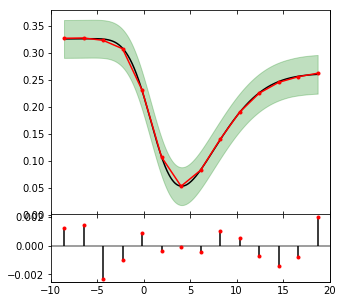

In [286]:
# Test Fit slits 
def slit_func(x, x0=0, sep=5, sigma1 = 5, sigma2=5, amp1=1, amp2=1, offset=0):
    return tp.erf_shifted(-x, -x0+sep, sigma1, amp1) + tp.erf_shifted(x, x0+sep, sigma2, amp2) + offset
guess = dict(x0=center, sep=4, sigma1=2, sigma2=5, amp1=0.3, amp2=0.3, offset=0)
trim = [1e-6*(center-width), 1e-6*(center+width)]


def temp(test=np.random.randint(df.shape[0])):
    r = df.iloc[test]
    tp.curve_fit(slit_func, guess, *r.nz.trim(trim).plotdata, plot=True, info=True)
if df.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df.shape[0]-1))

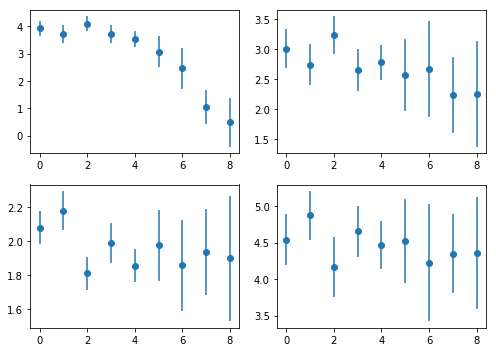

In [287]:
# Fit all 
df['fits'] = [tp.curve_fit(slit_func, guess, *r.nz.trim(trim).plotdata, plot=False, info=False) for n,r in df.iterrows()]
df['fit_center'] = [cf.fv['x0'] for cf in df['fits']]
df['fit_sep'] = [cf.fv['sep'] for cf in df['fits']]
df['fit_sigma1'] = [cf.fv['sigma1'] for cf in df['fits']]
df['fit_sigma2'] = [cf.fv['sigma2'] for cf in df['fits']]
df['err_center'] = [cf.fe['x0'] for cf in df['fits']]
df['err_sep'] = [cf.fe['sep'] for cf in df['fits']]
df['err_sigma1'] = [cf.fe['sigma1'] for cf in df['fits']]
df['err_sigma2'] = [cf.fe['sigma2'] for cf in df['fits']]

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[7,5])
ax = ax.flatten() 
xp = np.arange(df.shape[0])
ax[0].errorbar(xp, df['fit_center'], yerr = df['err_center'], fmt='o')
ax[1].errorbar(xp, df['fit_sep'], yerr = df['err_sep'], fmt='o')
ax[2].errorbar(xp, df['fit_sigma1'], yerr = df['err_sigma1'], fmt='o')
ax[3].errorbar(xp, df['fit_sigma2'], yerr = df['err_sigma2'], fmt='o')
plt.tight_layout()

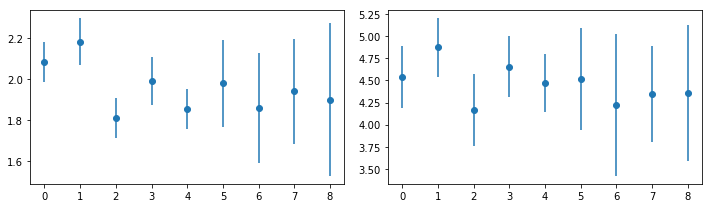

In [288]:
# Plot 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,3])
ax = ax.flatten() 
xp = np.arange(df.shape[0])
ax[0].errorbar(xp, df['fit_sigma1'], yerr = df['err_sigma1'], fmt='o')
ax[1].errorbar(xp, df['fit_sigma2'], yerr = df['err_sigma2'], fmt='o')
plt.tight_layout()

# Small Random Calculations

## Atom Number Fluctuations at Different Imaging Freq. -- Side Imaging

In [ ]:
# Entire Code Here 

print("\n============== LOADING IMAGES ==============")
# Initialize Dataframe
df = get_from_clipboard(init=True)
var = ['ImagFreq1','ImagFreq2','ImgPower1','ImgPower2']
x_var = 'ImagFreq1'

df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)
print("Total Images {}".format(df.shape[0]))
plt.show()

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 115, center_y = 354, width=190, height=190, 
                   subsample=1, od_method='log', bg_width=10)}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)

# Tests
print("\n============== Testing Crop Settings ==============")
test = -1
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

# ROI
print("\n============== Testing Region Of Interest ==============")
center_offset = [0, 0]
width, height = 80, 80
roi = tp.imagedata.get_cropi(df.image.iloc[test].od, 
                             center=(df.image.iloc[test].od.shape[1]//2 + center_offset[1], df.image.iloc[test].od.shape[0]//2 + center_offset[0]), 
                             width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Total Atoms 
print("\n============== Atom Nums ==============")
def imsum(od):
    od = od[roi]
    od = od[np.abs(od) < 10000]
    return np.nansum(od)
df['total_atoms'] = np.array([imsum(im.od) for im in df.image])

# Gather atom numbers with same x -- [x, y_mean, y_err, y, x_all, y_all]
atoms_binned = bin_data(df.x.values, df.total_atoms.values)

# Plots
plt.violinplot(atoms_binned[3], atoms_binned[0], showextrema=True, showmeans=True)
plt.plot(*atoms_binned[4:6], '.')
plt.xlabel('Imaging Frequency [Cicero Double Pass]')
plt.ylabel('Atom Numbers [Sum of OD]')
plt.title('Fluctuations in Atom Numbers on and away from Resonance')
plt.tight_layout()
plt.show()

# Display Information of the sigma and mean 
for x, y in zip(atoms_binned[0], atoms_binned[3]):
    print("Freq {} : Samples {:02d}; Mean {:.0f}; std. {:.0f}; std/mean {:.2f}".format(x, y.size, y.mean(), y.std(), y.std() / y.mean()))

## Simple Atom Numbers - Top


Updating the local database...
Done


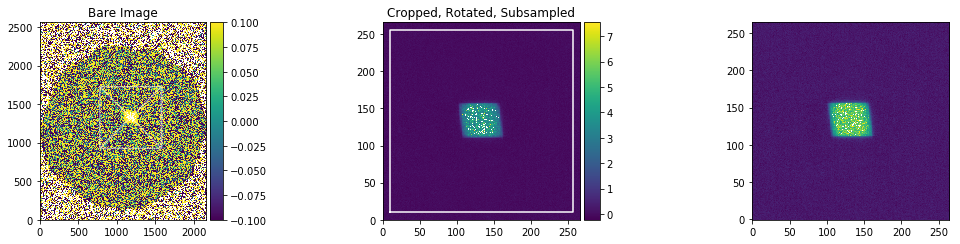

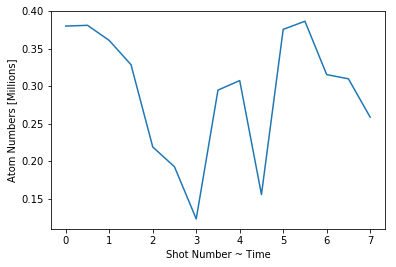

In [156]:
# Complete Procedure 

# Load Images
var = ['SeqMode','ImgPower1','SideGreenEvap']
x_var = 'SideGreenEvap'

# var = ['SideGreenEvap']
# x_var = 'SideGreenEvap'

df = get_from_clipboard(var=var, x_var=x_var, using=1)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1179, center_y = 1326, width = 800, height = 800, 
                   subsample = 3, bg_width = 10, od_method = 'table', fudge=1)}
for i, r in df.iterrows(): r.image.set(**settings)

# ROI
center_offset = [0, 0]
width, height = 600, 500
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=height)

# Test
test = 0
fig, ax = plt.subplots(ncols=3, figsize=(15, 3.5))
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[2].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Total Atoms
df['total_atoms'] = np.array([np.nansum(im.app[roi]) for im in tqdm(df.image, desc='Atoms')])

# Plots
plt.plot(df.shot, df.total_atoms/1e6)
plt.xlabel('Shot Number ~ Time')
plt.ylabel('Atom Numbers [Millions]')

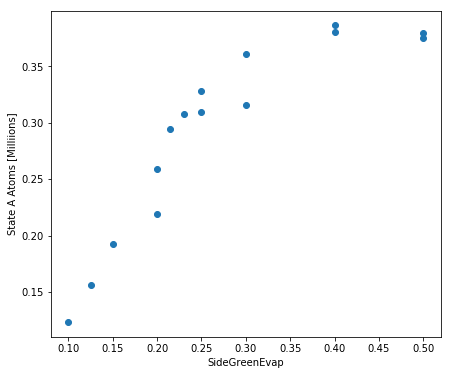

In [157]:
# Plot -- Atom numbers vs x 
xvar = x_var
plt.subplots(figsize=(7,6))
atoms_x = tp.Curve(x = df.x.values, y = df.total_atoms.values, yscale=1e6).sortbyx()
plt.plot(*atoms_x.plotdata, 'o')
plt.xlabel(xvar)
plt.xlim([None,None])
plt.ylabel('State A Atoms [Milliions]')
# plt.ylim([0.1,0.45])
plt.show()

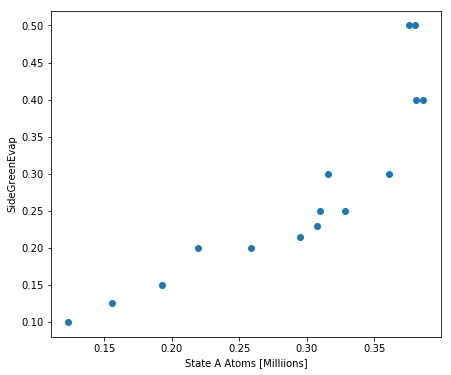

In [158]:
# Plot -- Atom numbers as x-axis
xvar = x_var
plt.subplots(figsize=(7,6))
atoms_x = tp.Curve(x = df.x.values, y = df.total_atoms.values, yscale=1e6).sortbyx()
plt.plot(atoms_x.y/1e6, atoms_x.x, 'o')
plt.ylabel(xvar)
plt.xlim([None,None])
plt.xlabel('State A Atoms [Milliions]')
# plt.ylim([0.1,0.45])
plt.show()

N1 / N3 = 1.125 +/- 0.497


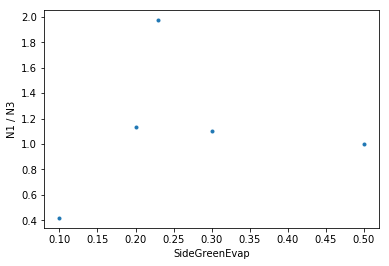

In [154]:
# TopA /TopB 
atoms_ratio = tp.Curve(x = df.x.iloc[::2].values, y = df.total_atoms.iloc[::2].values / df.total_atoms.iloc[1::2].values, yscale=1).sortbyx()
print("N1 / N3 = {:.3f} +/- {:.3f}".format(np.mean(atoms_ratio.y), np.std(atoms_ratio.y)))
plt.plot(*atoms_ratio.plotdata, '.')
plt.xlabel(xvar)
plt.xlim([None,None])
plt.ylabel('N1 / N3')
plt.show()

Mean 1.796 +- 0.038


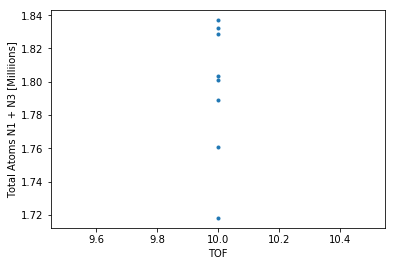

In [2360]:
# Plot -- Atom numbers vs x 
xvar = x_var
atoms_x = tp.Curve(x = df.x.iloc[::2].values, y = df.total_atoms.iloc[::2].values + df.total_atoms.iloc[1::2].values, yscale=1e6).sortbyx()
print('Mean {:.3f} +- {:.3f}'.format(np.mean(atoms_x.y)/1e6, np.std(atoms_x.y)/1e6 ))
plt.plot(*atoms_x.plotdata, '.')
plt.xlabel(xvar)
plt.xlim([None,None])
plt.ylabel('Total Atoms N1 + N3 [Milliions]')
plt.show()


Mean 0.955 +- 0.043


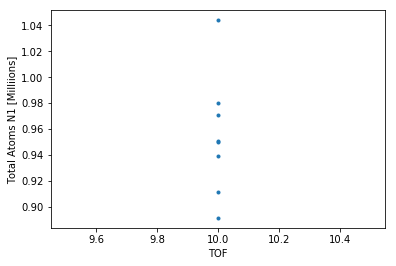

In [2361]:
# Plot -- TopA vs x
xvar = x_var
atoms_x = tp.Curve(x = df.x.iloc[::2].values, y = df.total_atoms.iloc[1::2].values, yscale=1e6).sortbyx()
print('Mean {:.3f} +- {:.3f}'.format(np.mean(atoms_x.y)/1e6, np.std(atoms_x.y)/1e6 ))
plt.plot(*atoms_x.plotdata, '.')
plt.xlabel(xvar)
plt.xlim([None,None])
plt.ylabel('Total Atoms N1 [Milliions]')
plt.show()

In [2362]:
# print the infomation
volume=1.01e6
num_S1=np.mean(atoms_x.y);
density=np.mean(atoms_x.y)/volume
EF=zs.thermodynamics.n2EF(density)
vF = (2 * EF*cst.h / cst.mass)**(1/2) * 1e3
xi = 0.37
zeroTLimit = (xi/3)**(1/2)
c_0=vF*zeroTLimit

print('Fudge: {:.2f}'.format(settings['fudge']))
print('Volume: {:.2f}*1e6 um^3'.format(volume/1e6))
print('Total atom: {:.2f} +- {:.2f} million'.format(np.mean(atoms_x.y)/1e6, np.std(atoms_x.y)/1e6))
print('State 1 density: {:.2f} +- {:.2f} um^(-3)'.format(np.mean(atoms_x.y)/volume, np.std(atoms_x.y)/volume))
print('E_F: {:.2f} kHz'.format(EF))
print('v_F: {:.2f} um/ms'.format(vF))
print('c(T=0): {:.2f} um/ms'.format(c_0))
print('v_F*0.38: {:.2f} um/ms'.format(vF*0.38))

Fudge: 1.82
Volume: 1.01*1e6 um^3
Total atom: 0.95 +- 0.04 million
State 1 density: 0.95 +- 0.04 um^(-3)
E_F: 12293.75 kHz
v_F: 40.39 um/ms
c(T=0): 14.18 um/ms
v_F*0.38: 15.35 um/ms


In [2363]:
# # Exponential Fit 

# atoms_x.plotdata[1]
# def expdecay(t,a,tau):
#     return np.exp(-t/tau)*a
# fitres,J=scipy.optimize.curve_fit(expdecay,atoms_x.plotdata[0],atoms_x.plotdata[1],[3,20])
# xfit=np.linspace(0,35,100)
# yfit=expdecay(xfit,fitres[0],fitres[1])
# plt.plot(*atoms_x.plotdata, '.')
# plt.plot(xfit,yfit)
# plt.xlabel('ODT wait time')
# plt.xlim([None,None])
# plt.ylabel('Total Atoms N1 + N3 [Milliions]')
# plt.show()
# print('Life time: {}ms',fitres[0])  


In [2364]:
# # Specialized Plot -- Fractional Imbalance vs. total atoms 

# # Gather Data
# x1 = []
# x2 = []
# y1 = []
# for i in tqdm(range(df.shape[0]//2)):
#     xi = (df.image.iloc[2*i].total_atoms + df.image.iloc[2*i+1].total_atoms)
#     yi = (df.image.iloc[2*i].total_atoms - df.image.iloc[2*i+1].total_atoms) / xi
#     x1.append(xi / 1e6)
#     x2.append(df.IREvap.iloc[2*i])
#     y1.append(yi)

# imbalance_atoms = tp.Curve(np.array(x1), np.array(y1)).sortbyx()
# imbalance_IR = tp.Curve(np.array(x2), np.array(y1)).sortbyx()

# # Compute histogram and Gaussian Fit for values below some IR Evap Threshold 
# IR_threshold = 4
# imbalance_threshold = 0.3
# imbalance_atoms_below = imbalance_atoms.trim(xlim = [0, IR_threshold])
# stats = [np.mean(imbalance_atoms_below.y), np.std(imbalance_atoms_below.y)]
# suptitle = 'Below {} IR Evap, the Mean Imbalance = {:.2f} and std. = {:.2f}'.format(IR_threshold, *stats)

# # Plots
# plt.figure(figsize=(10, 4))
# ax1 = plt.subplot(121)
# plt.plot(*imbalance_atoms.data, '.')
# plt.axhline(0, linestyle='--', c='k', alpha=0.5)
# plt.xlabel('Total Atoms N1 + N3 [Millions]')
# plt.xlim([0,None])
# plt.ylabel('Imbalance (N1 - N3) / (N1 + N3) ')

# ax2 = plt.subplot(122, sharey = ax1)
# plt.semilogx(*imbalance_IR.data, '.')
# # plt.plot(*imbalance_IR.data, '.')
# plt.axhline(0, linestyle='--', c='k', alpha=0.5)
# plt.xlabel('IR Evap [Cicero V]')
# plt.xlim([0.1, None])

# plt.suptitle(suptitle, y = 1.04)
# plt.tight_layout()

In [2365]:
# # Plots
# mask=[0,2,4,6]
# num=np.mean(df.total_atoms[mask]/1e6)
# numerr=np.std(df.total_atoms[mask]/1e6)

# plt.plot(df.shot[mask], df.total_atoms[mask]/1e6)
# plt.xlabel('Shot Number ~ Time')
# plt.ylabel('Atom Numbers [Millions]')

# print('''Atom number = {:.3f} +/- {:.3f}'''.format(num,numerr))

## Averaged Image - Top

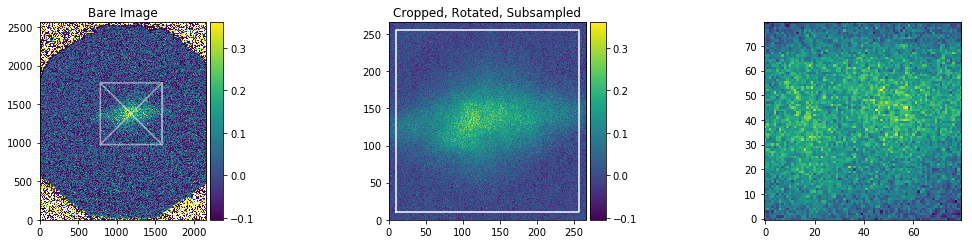

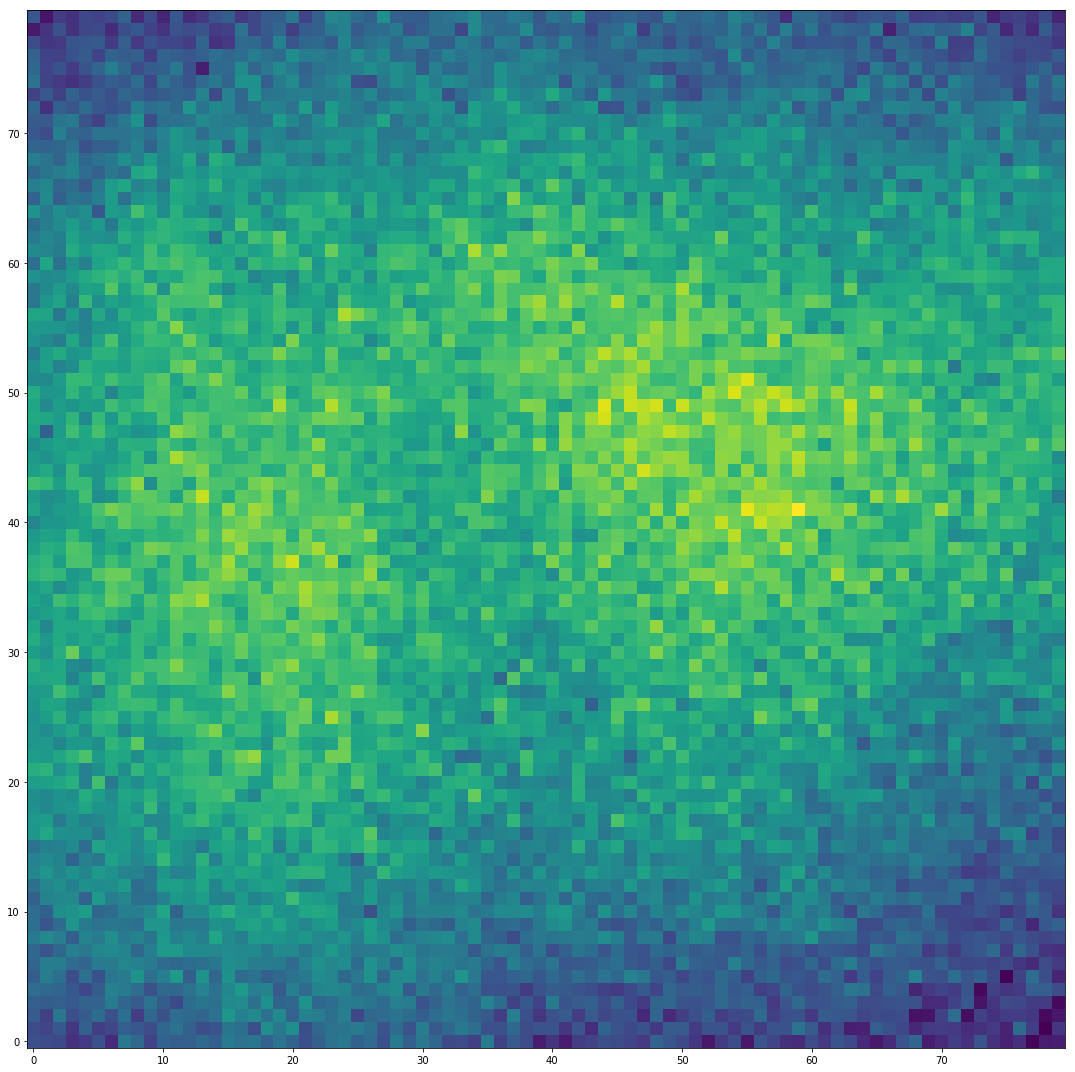

In [2355]:
# Complete Procedure 

# Load Images
df = get_from_clipboard(using=0)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1185, center_y = 1375, width = 800, height = 800, 
                   subsample = 3, bg_width = 10, od_method = 'table', fudge=1)}
for i, r in df.iterrows(): r.image.set(**settings)

# ROI
center_offset = [0, 0]
width, height = 80, 80
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=height)

# Test
test = 0
fig, ax = plt.subplots(ncols=3, figsize=(15, 3.5))
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[2].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Average Image
avg_app = np.mean([im.app[roi] for im in df.image], axis=0)

# Plots
plt.figure(figsize=[15,15])
plt.imshow(avg_app, origin=0)
plt.tight_layout()

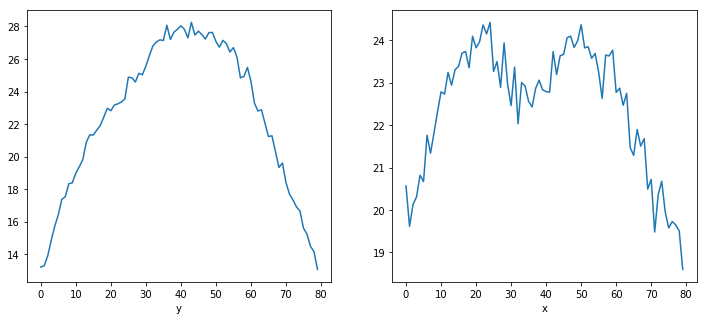

In [1918]:
# Cuts through center 
thickness = 5

fig, ax = plt.subplots(ncols=2, figsize=[12, 5])
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=thickness, height=height)
ax[0].plot(np.mean(avg_app, axis=1))
ax[0].set(xlabel='y')
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=thickness)
ax[1].plot(np.mean(avg_app, axis=0))
ax[1].set(xlabel='x')

## Averaged Image - Side


Updating the local database...
Done


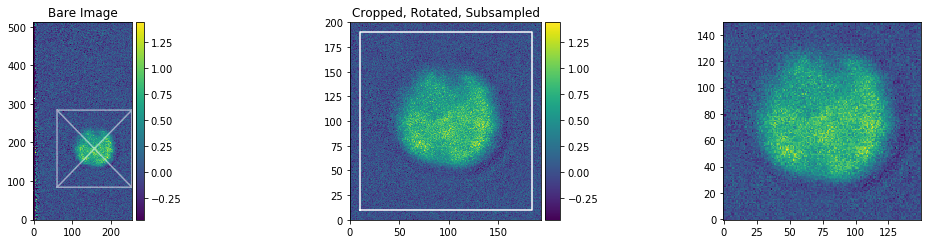

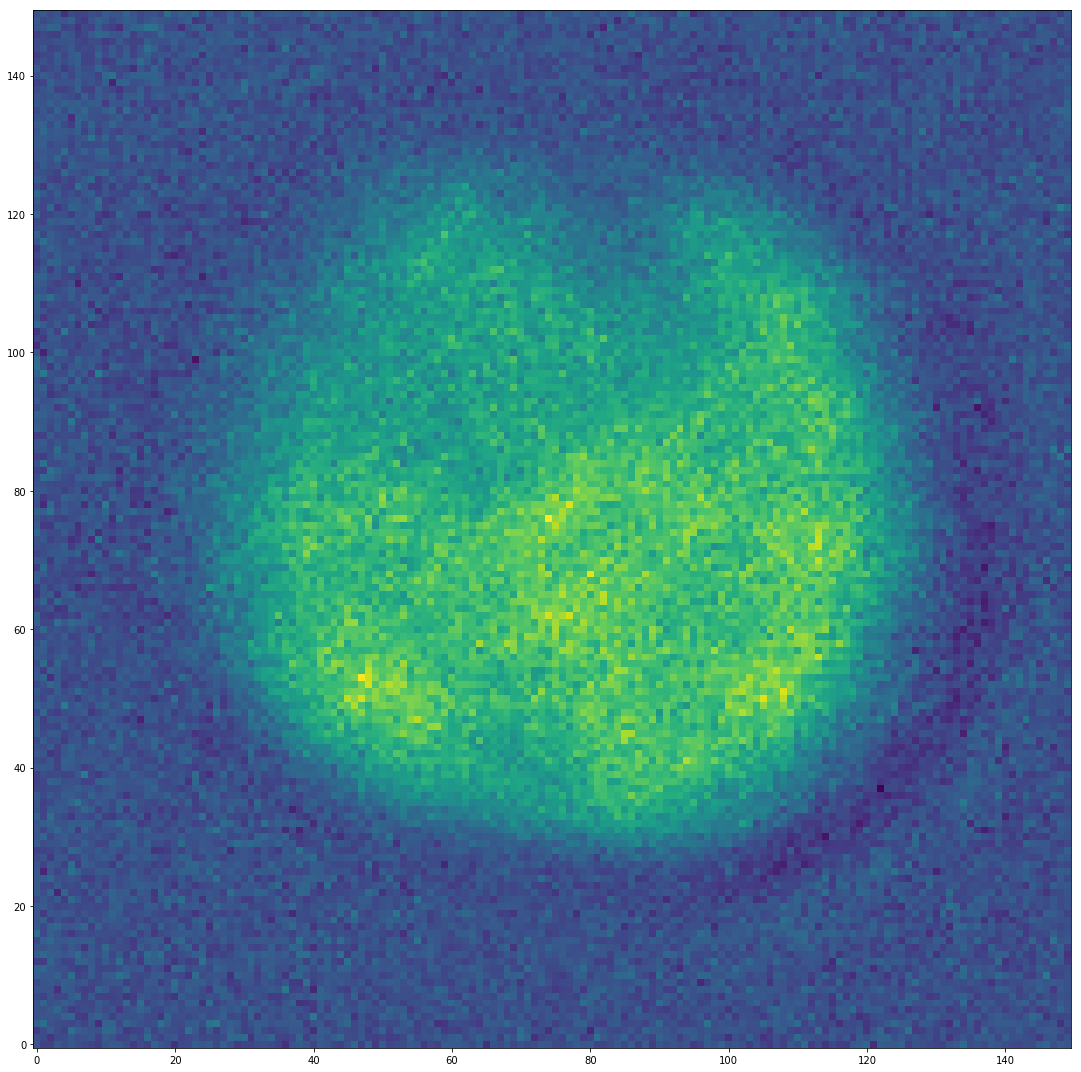

In [8]:
# Complete Procedure 

# Load Images
df = get_from_clipboard()

# Crop images
settings = {**default_settings, 
            **dict(center_x = 161, center_y = 184, width = 200, height = 200, 
                   subsample = 1, bg_width = 10, od_method = 'log', fudge=1)}
for i, r in df.iterrows(): r.image.set(**settings)

# ROI
center_offset = [0, 0]
width, height = 150, 150
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=height)

# Test
test = 0
fig, ax = plt.subplots(ncols=3, figsize=(15, 3.5))
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[2].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Average Image
avg_app = np.mean([im.app[roi] for im in df.image], axis=0)

# Plots
plt.figure(figsize=[15,15])
plt.imshow(avg_app, origin=0)
plt.tight_layout()

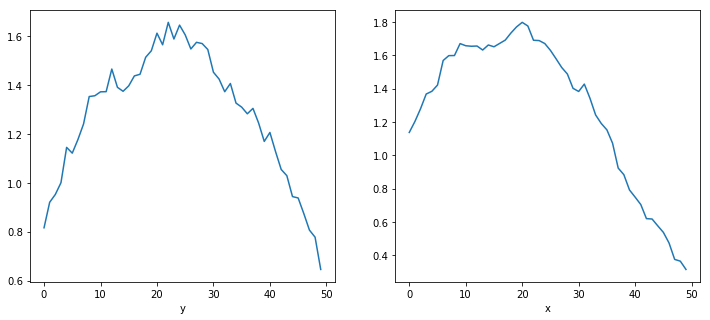

In [321]:
# Cuts through center 
thickness = 0
center_offset = [0,0]

fig, ax = plt.subplots(ncols=2, figsize=[12, 5])
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=thickness, height=height)
ax[0].plot(np.mean(avg_app, axis=1))
ax[0].set(xlabel='y')
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=thickness)
ax[1].plot(np.mean(avg_app, axis=0))
ax[1].set(xlabel='x')

# Fine Calculations

    FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
a0      1.68  0.087250  None    0.0        -inf         inf   5.193431
a1      1.71  0.026458  None    1.0        -inf         inf   1.547223
a2      0.00  0.000000   NaN    0.0    0.000000    0.000000   0.000000


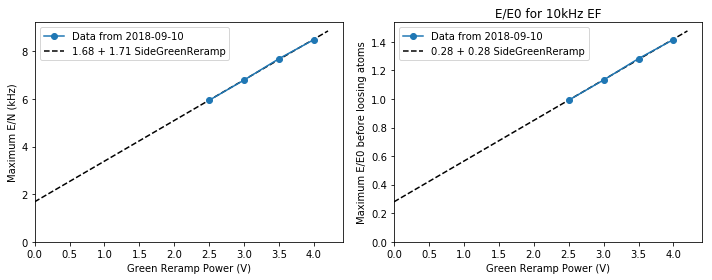

In [251]:
# Temp stuff 
x = np.array([2.5, 3, 3.5, 4])
y = np.array([5.95, 6.8, 7.7, 8.5])
def poly(x, a0=0, a1=0, a2=0): return a0 + a1*x + a2*x**2
cf = tp.curve_fit(poly, [0,1], x, y, info=True)
xp = np.linspace(0, 4.2)

fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
plt.sca(ax[0])
plt.plot(x, y, 'o-', zorder=1, label='Data from 2018-09-10')
plt.plot(xp, cf(xp), 'k--', zorder=0, label='{:.2f} + {:.2f} SideGreenReramp'.format(cf.fv[0], cf.fv[1]))
plt.legend()
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Green Reramp Power (V)')
plt.ylabel('Maximum E/N (kHz)') 
plt.sca(ax[1])
plt.plot(x, y/6, 'o-', zorder=1, label='Data from 2018-09-10')
plt.plot(xp, cf(xp)/6, 'k--', zorder=0, label='{:.2f} + {:.2f} SideGreenReramp'.format(cf.fv[0]/6, cf.fv[1]/6))
plt.legend()
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Green Reramp Power (V)')
plt.ylabel('Maximum E/E0 before loosing atoms') 
plt.title('E/E0 for 10kHz EF')
plt.tight_layout()

In [ ]:
2 * 0

In [ ]:
0**10

In [ ]:
round(np.sin(np.pi))

In [ ]:
round(np.exp(1j*np.pi) + 1)

In [ ]:
np.log(1)

In [ ]:
1/np.inf

# Hyperfine Calculations

## Making Plots using Stored Data

In [ ]:
# saved_DS4 = cond_frac_binned
# saved_DS7 = cond_frac_binned
# saved_DS47 = cond_frac_binned

In [ ]:
fontsize = 14

plt.figure(figsize=[6,5])
# plt.errorbar(*saved_DS4[0:2], yerr = saved_DS4[2], fmt='o-', label='DS4 - Beginning')
# plt.errorbar(*saved_DS7[0:2], yerr = saved_DS7[2], fmt='o-', label='DS7 - End')
plt.errorbar(*saved_DS47[0:2], yerr = saved_DS47[2], fmt='o-', label='Combined')
plt.xlabel('Wait time in Box [s]', fontsize=fontsize)
plt.ylabel('Condensate Fraction', fontsize=fontsize)
# plt.title('at Beginning and End of Datasets', fontsize=15)
plt.legend()
plt.ylim([0,None])
plt.tight_layout()

## Contact Plots

In [ ]:
import virial

In [ ]:
dfold = pd.read_clipboard()
c = t`ap.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
dfold['T/TF'] = c(dfold['E/E0'].values)

In [ ]:
dfnew = pd.read_clipboard()
cnew = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
dfnew['T/TF'] = cnew(dfnew['E/E0'].values)

In [ ]:
fig, ax = plt.subplots(figsize=[6, 5], ncols=1, sharey=True)

plt.errorbar(dfold['T/TF'], dfold['Contact'], dfold['Contact_Error'], fmt = 'bo', label='05-31')
plt.errorbar(dfnew['T/TF'], dfnew['Contact'], dfnew['Contact_Error'], fmt = 'bo', label='06-01')
plt.axvline(0.17, linestyle='--', color='r', alpha=0.5)
plt.xlim([0,0.7])

plt.xlabel('T/T$_F$', fontsize=17)
plt.ylabel('C / N k$_F$', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# # Virial plotting
# plt.xlim([0,1.7])
# plt.ylim([1,3.7])
# vir = virial.VirialUnitarity(BetaMuRange=[-5,0])
# CvT = vir.TTilde
# CvC = vir.CI_NkF
# plt.plot(CvT, CvC,'g-', linewidth=2, label='3rd order virial')


# plt.legend()
plt.tight_layout()
plt.savefig('contact.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=[6, 5], ncols=1, sharey=True)
df_main = pd.concat([dfold,dfnew])
plt.errorbar(df_main['T/TF'], df_main['Contact'], df_main['Contact_Error'], fmt = 'bo', label='data')
plt.axvline(0.17, linestyle='--', color='r', alpha=0.5)
plt.xlim([0,0.7])

plt.xlabel('T/T$_F$', fontsize=17)
plt.ylabel('C / N k$_F$', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Virial plotting
plt.xlim([0,1.7])
plt.ylim([1,3.7])
vir = virial.VirialUnitarity(BetaMuRange=[-5,0])
CvT = vir.TTilde
CvC = vir.CI_NkF
plt.plot(CvT, CvC,'g-', linewidth=2, label='3rd order virial')


plt.legend()
plt.tight_layout()
plt.savefig('contact_with_virial.pdf')

In [ ]:
dfold['EF'] 

In [ ]:
fig, ax = plt.subplots(figsize=[6, 5], ncols=1, sharey=True)

plt.plot(dfold['EF'], dfold['Contact'],'ro', label='05-31')
plt.plot(dfnew['EF'], dfnew['Contact'], 'bo',label='06-01')
plt.axvline(0.17, linestyle='--', color='r', alpha=0.5)
plt.xlabel('T/T$_F$', fontsize=15)
plt.ylabel('C / N k$_F$', fontsize=15)

plt.legend()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=[10, 4], ncols=2, sharey=True)

ax[0].errorbar(dfold['E/E0'], dfold['Contact'], dfold['Contact_Error'], fmt = 'bo', label='05-31')
ax[0].errorbar(dfnew['E/E0'], dfnew['Contact'], dfnew['Contact_Error'], fmt = 'ro', label='06-01')

ax[0].axvline(0.37, linestyle='--', c='k', alpha=0.5)
ax[0].axvline(0.54, linestyle='--', color='r', alpha=0.5)
ax[0].set_xlabel('E/E$_0$', fontsize=15)
ax[0].set_ylabel('C / N k$_F$', fontsize=15)

ax[0].legend()

ax[1].errorbar(dfold['T/TF'], dfold['Contact'], dfold['Contact_Error'], fmt = 'bo', label='05-31')
ax[1].errorbar(dfnew['T/TF'], dfnew['Contact'], dfnew['Contact_Error'], fmt = 'ro', label='06-01')
ax[1].axvline(0.17, linestyle='--', color='r', alpha=0.5)
ax[1].set_xlabel('T/T$_F$', fontsize=15)

plt.legend()

plt.tight_layout()

In [ ]:
dfnew['T/TF']

## bec lifetime

In [ ]:
# Initialize Dataframe 
df = get_from_clipboard(init=True)
var = ['waittime']
x_var = 'waittime'

# Import from Clipboard
df = get_from_clipboard(df=df, init=False, var=var, x_var=x_var, image_func=tp.Image, using=2)

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 380, center_y = 80, width=240, height=1000, bg_width=0, subsample=1, od_method='log')}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)

# Tests
test = -1
print(df.image.iloc[test].name)
df.image.iloc[test].plot_crop()
print(df.x.iloc[test])

In [ ]:
# Fits and calc atom nums 
guess = [110, 300, 100, 100, 1, 0]
def atom_num_calc(od, plot=False):
    fr = fit_gaussian_2d(np.nan_to_num(od), plot=plot, guess=guess, )
    return fr[2] * fr[3] * fr[4]
df['total_atoms'] = [atom_num_calc(im.od, plot=True) for im in tqdm(df.image)]
lifetime_curve = tp.Curve(df.x.values, df.total_atoms.values)

In [ ]:
# Get lifetime 
def expfun(t, tau=20, amp=1, off=0):
    return off + amp*np.exp(-t/tau)

# plt.plot(*lifetime_curve.data, '.')
fr, fe = lifetime_curve.fit(expfun, [20, 10000], plot=True, xlim=[0, 100])